# Sequence Analysis and Functional Prediction Pipeline

## 1. Introduction
This notebook analyzes the functional and sequence relationships between newly identified bacteria and known corrosion-influencing microorganisms. The analysis builds upon previous findings where:
- Statistical significance was established between the selected bacteria and corrosion risk (Notebook 3)
- Literature validation confirmed corrosion influence for many bacteria (Notebook 4)
- Evolutionary relationships were mapped through phylogenetic analysis (Notebook 5)

The study focuses on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
We implement two classification strategies:

1. Simple Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Other bacteria (combining checked_taxa and core_taxa)

2. Detailed Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Pure checked bacteria (exclusive to checked_taxa)
   - Pure core bacteria (exclusive to core_taxa)
   - Checked-core bacteria (overlap between checked and core taxa)

This detailed approach allows for more nuanced analysis of functional profiles and better understanding of potential corrosion mechanisms across different bacterial groups.

### Analysis Goals:
- Predict metabolic functions from 16S sequences
- Focus on corrosion-relevant pathways (sulfur/iron metabolism)
- Compare functional profiles between known corrosion-causing bacteria and newly identified candidates
- Validate whether statistical correlations reflect genuine metabolic capabilities associated with corrosion processes

### Directory Structure:
 Following is the structure of the notebook data named data_picrus  
data_tree  
 ├── sequences/  
 │   ├── known.fasta : sequences of known corrosion-causing bacteria  
 │   ├── candidate.fasta : sequences of potential new corrosion-causing bacteria  
 |   └── other files  
 data_picrus  
 └── picrust_results/  
      ├── known_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      ├── candidate_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  : final comparison summary
      ├── core_bacteria/
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      │      
      └── functional_comparison.xlsx  

Picrust2 works using its reference database that was installed with the package   
~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf

# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [2]:
# Colab specific
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')

Mounted at /content/drive


__Importing PICRUST IN COLAB__

In [3]:
'''# Install miniconda and initialize:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3
!conda config --add channels defaults
!conda config --add channels bioconda
!conda config --add channels conda-forge
# Imports for colab
import condacolab
import sys
sys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')

# Install PICRUSt2 and its dependencies
%conda install -c bioconda -c conda-forge picrust2=2.4.1 -y
# Verify installations%
%conda list | grep picrust2'''

"# Install miniconda and initialize:\n!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh\n!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3\n!conda config --add channels defaults\n!conda config --add channels bioconda\n!conda config --add channels conda-forge\n# Imports for colab\nimport condacolab\nimport sys\nsys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')\n\n# Install PICRUSt2 and its dependencies\n%conda install -c bioconda -c conda-forge picrust2=2.4.1 -y\n# Verify installations%\n%conda list | grep picrust2"

### Using Pro colab

In [4]:
'''import sys
print([module for module in sys.modules if 'tensorflow' in module])'''

"import sys\nprint([module for module in sys.modules if 'tensorflow' in module])"

In [5]:
# Set up memory footprint support libraries
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
!pip install memory_profiler
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=55d2f641ed9f29be665e0489eac7206186511e0ff0f038ef9437bdcd3dee8d42
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built gputil
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


### Kaggle / Colab

In [6]:
!pip install biopython
from IPython import get_ipython
from IPython.display import display
!pip install biom-format
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for biom-format: filename=biom_format-2.1.16-cp311-cp311-linux_x86_64.whl size=12182962 sha256=5878150071b1b436b15812ab761eb1a0e8f6d85d2daecf8d8038599c9cb47482
  Stored in directory: /root/.cache/pip/wheels/a5/6b/58/a879e8fbae2479a3d1a68719f3a062fe62701d6494f1b74f5e
Successfully built biom-format
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00


# 2.2. Importing Libraries,  Making Directories and Loading Data

In [7]:
# Standard library imports
import os
import sys
import ast
import subprocess
import logging
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
# Data processing imports
import pandas as pd
import numpy as np
import openpyxl
import re
import matplotlib.pyplot as plt
import gzip
#%matplotlib inline
#plt.style.use('seaborn')
import seaborn as sns
from natsort import natsorted

In [8]:
import umap
# datascience libraries
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist
import networkx as nx
from sklearn.cluster import AgglomerativeClustering, KMeans

# from Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# BIOM handling
from biom import Table
from biom.util import biom_open
from biom import load_table

#imports retrieval
import requests
import time
import json

In [46]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Directory Structure Definitions
SIMPLE_BASE = {
    'known': 'simple_known_mic',
    'other': 'simple_candidate_mic'
}

DETAILED_BASE = {
    'known': 'detailed_known_mic',
    'pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic',
    'checked_core': 'detailed_checked_core_mic'
}

SUBDIRS = [
    'EC_predictions',
    'pathway_predictions',
    'KO_predictions',
    'other_picrust_files'
]

# Base Paths
if "google.colab" in sys.modules:
    base_dir = Path("/content/drive/MyDrive/MIC/data_picrust")
else:
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")

# Create output directory if it doesn't exist
base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")
fasta_file_final = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta")
aligned_fasta = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/aligned-dna-sequences_gg.fasta")
large_dir = Path("/home/beatriz/MIC/MIC_large")
output_dir = base_dir
output_dir.mkdir(parents=True, exist_ok=True)


# for colab
# Create output directory if it doesn't exist
base_dir = Path("/content/drive/MyDrive/MIC/data_picrust/")
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")
fasta_file_final = Path("/content/drive/MyDrive/MIC/data_picrust/final_sequences_gg.fasta")
aligned_fasta = Path("/content/drive/MyDrive/MIC/data_picrust/aligned-dna-sequences_gg.fasta")
results_file = base_dir / "/content/drive/MyDrive/MIC/data_picrust/functional_comparison.xlsx"
output_dir = base_dir  # Separate output directory
output_dir.mkdir(parents=True, exist_ok=True)
large_dir = Path("/content/drive/MyDrive/MIC/MIC_large")
large_dir.mkdir(parents=True, exist_ok=True)
db_dir = Path("/content/drive/MyDrive/MIC/Databases")
db_dir.mkdir(parents=True, exist_ok=True)

'''
# For Kaggle work
base_dir = Path("/kaggle/input/data-picrust")
abundance_excel= base_dir / "merged_to_sequence.xlsx"
fasta_file_final = base_dir / "final_sequences_gg.fasta"
output_dir = Path("/kaggle/working/") '''

'\n# For Kaggle work\nbase_dir = Path("/kaggle/input/data-picrust")\nabundance_excel= base_dir / "merged_to_sequence.xlsx"\nfasta_file_final = base_dir / "final_sequences_gg.fasta"\noutput_dir = Path("/kaggle/working/") '

The fasta file come from the Alternative Sequences finding from the Greenes Genes Database, from the taxonomy in this study made in section 7 in the 5_Sequences_qiime notebook: final_sequences_gg.fasta. Abundance dataframe come from the data from notebook 4 merged_to_sequence.xlsx sheet=core_check_usual_taxa which is a unified df between 3 different groups explained previously: cora_taxa (>20% 60 abundance features), usual_taxa (17 high literature ranking bacteria influencing corrosion) and checked_taxa (30 statistically significant to the corrosion risk label) in total 85 features.

In [26]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

In [ ]:
Integrated_T.tail()

## 2.3. Making Sequences for Picrust fasta file

Picrust Functional Analyiss requires a biom table with otus as index, samples as headers and abundance as values. The present biom has genus names but is needs instead Otus instead. The other input file for picrust is the representative sequences table that consist of the sequences per genera followed by the frequency of that genera on the whole sample, this is done directly by the software. The fasta file requires the otus instead of the genera names and the sequences non aligned coming from notebook 5. The following scrips will formate the data to picrust.

In [27]:
# Read and modify sequences
new_records = []
for record in SeqIO.parse(fasta_file_final, "fasta"):
    match = re.search(r"\s(\d+)\s", record.description)  # Look for digits surrounded by spaces
    if match:
        otu_id = match.group(1)
    else:
        print(f"Warning: Could not extract OTU ID from description: {record.description}")
        continue  # Skip this record if OTU ID not found

    # Create new record with only OTU as ID
    new_record = SeqRecord(
        record.seq,
        id=otu_id,
        description=""  # Empty description to keep only ID
    )
    new_records.append(new_record)

# Write modified FASTA
output_fasta_path = Path(output_dir / "sequences_for_picrust.fasta")

SeqIO.write(new_records, output_fasta_path, "fasta")

85

In [ ]:
new_record

## 2.4. Making of Dataframes for 2 Different Pipelines
The following script is the path to the biom file but also to the Integrate dataframe which create dataframes that discriminate its origin in order to pass then through picrust different pipelines, to know: Simple_Base that compares the known bacteria namely usual_taxa against the other features to understand their relationships on the function of their metabolism, an additional group is put forward as simply_candidate_mic which corresponds to the bacteria no previously linked to corrosion but showing an statistical significance with the risk label, those come from the checked_taxa and in this study are: genera(GID): Bulleida (154); Mycoplana (471), Oxobacter (512) and Oerskovia (). Also as showing an favor behaviour against corrosion are presented: Phenylobacterium (549), Gelria(334), Porphyrobacteria (564) and Tepidimonas (712)
SIMPLE_BASE = {'known': 'simple_known_mic', 'other': 'simple_candidate_mic'}
The second pipeline comprises a more detailed separation of the bacteria and that is: The Known bacteria as previously, pure_checked corresponding to the statistical significant genera, pure_core correspondent to the core taxa on the systems and the combination of the core and checked taxa.
DETAILED_BASE = {'known': 'detailed_known_mic','pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic', 'checked_core': 'detailed_checked_core_mic'}

__Making the Integrated dataframe__
The original dataframe has a column for source, indicating from which df  came from (core, usual, checked), this script proceses that datadrame into individual dfs and the combined preserving the source for further analysis. The Integrated dataframe continues to be process on the next step to become the biom abundance df.

In [28]:
def process_integrated_data(df):
    """
    Process the integrated DataFrame to create a new DataFrame with clear column names
    and preserve all values including source information.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with MultiIndex index and site columns

    Returns:
    pandas.DataFrame: Processed DataFrame with clear structure
    """

    # Extract genera and GIDs from the index MultiIndex
    genera = df.index.get_level_values(6)[1:]  # Skip first row
    gids = pd.to_numeric(df.index.get_level_values(7)[1:], errors='coerce')

    # Create a new DataFrame with the extracted information
    result_df = pd.DataFrame({
        'Genus': genera,
        'GID': gids
    })

    # Add the site values from the original DataFrame
    for col in df.columns:
        result_df[col] = df.iloc[1:][col].values

    # Clean up the DataFrame
    result_df['GID'] = pd.to_numeric(result_df['GID'], errors='coerce')
    result_df = result_df.dropna(subset=['GID'])
    result_df['GID'] = result_df['GID'].astype(int)

    return result_df

def get_taxa_groups(df):
    """
    Separate the processed DataFrame into different taxa groups based on Source column

    Parameters:
    df (pandas.DataFrame): Processed DataFrame from process_integrated_data()

    Returns:
    dict: Dictionary containing DataFrames for different taxa groups
    """
    # Split the data into groups based on 'Source' column patterns

    # Known corrosion bacteria (any pattern with 'us')
    known_bacteria = df[df['Source'].str.contains('us', case=False, na=False)]

    # Pure checked bacteria (only 'chk' without 'core' or 'us')
    pure_checked = df[
        df['Source'].str.contains('chk', case=False, na=False) &
        ~df['Source'].str.contains('core|us', case=False, na=False)
    ]

    # Pure core bacteria (only 'core' without 'chk' or 'us')
    pure_core = df[
        df['Source'].str.contains('core', case=False, na=False) &
        ~df['Source'].str.contains('chk|us', case=False, na=False)
    ]

    # Checked-core bacteria (contains both 'core' and 'chk' but no 'us')
    checked_core = df[
        df['Source'].str.contains('chk.*core|core.*chk', case=False, na=False) &
        ~df['Source'].str.contains('us', case=False, na=False)
    ]

    # Create groups dictionary
    taxa_groups = {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

    # Print summary statistics
    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")

    # Verify total matches expected
    total_classified = len(known_bacteria) + len(pure_checked) + len(pure_core) + len(checked_core)
    print(f"\nTotal classified taxa: {total_classified}")
    print(f"Total in dataset: {len(df)}")

    return taxa_groups

# Usage example:
Integrated = process_integrated_data(pre_Integrated)

# Get the groups
taxa_groups = get_taxa_groups(Integrated)

# Access individual groups -
known_bacteria = taxa_groups['known_bacteria']
pure_core = taxa_groups['pure_core']
pure_checked = taxa_groups['pure_checked']
checked_core = taxa_groups['checked_core']


Detailed Classification Results:
Known corrosion bacteria: 17
Pure checked bacteria: 19
Pure core bacteria: 46
Checked-core bacteria: 3

Total classified taxa: 85
Total in dataset: 85


In [ ]:
checked_core

## 2.5. Making the Abundanc Biom dataframe for Picrust

The final biom should have as index the Otus numbers no the genera names and a clean formate

In [29]:
# droping source and genus and putting GID as index
pre_biom= Integrated.drop(columns=["Source", "GID"])
pre_biom= pre_biom.set_index("Genus").astype(str)
# Ensure all data values are float
pre_biom = pre_biom.astype(float)

__changing genera to otus__

In [30]:
# Create genus to OTU mapping from FASTA headers
genus_to_otu = {}
for record in SeqIO.parse(fasta_file_final, "fasta"):
    parts = record.description.split()
    if len(parts) >= 3:
        genus = parts[0]
        otu = parts[1]  # We'll use the first OTU number
        genus_to_otu[genus] = otu

# Print a few mappings to verify
print("Sample genus to OTU mappings:")
for i, (genus, otu) in enumerate(list(genus_to_otu.items())[:5]):
    print(f"{genus} -> {otu}")

# Replace genus with OTU in the index
pre_biom.index = pre_biom.index.map(lambda x: genus_to_otu.get(x, x))

# Remove the 'Genus' name from the index
pre_biom.index.name = "OTU"

Sample genus to OTU mappings:
Corynebacterium -> 1042616
Caulobacter -> 866365
Legionella -> 838066
Sediminibacterium -> 781203
Smithella -> 713656


__Calculation counts for picrust2__

In [ ]:
scaling_factor = 10000
# Multiply by scaling factor and round to nearest integer
count_pre_biom = np.round(pre_biom * scaling_factor).astype(int)
count_pre_biom

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
OTU,,,,,,,,,,,,,,,,,,,,,
690515,269280,18592,30935,25740,27094,0,21462,5400,39032,0,...,3533,5713,6241,2600,45182,4000,49,0,14700,17200
519902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,544,0,0,212,0,0
1134896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2177,0,0,0,0,0
336037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5444,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7621,0,0,0,0,0
556957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162379,1723,190,0,66,184,0,461,0,89,0,...,0,1439,1156,0,25585,0,0,0,0,0


__Creating the biom table formate__

In [ ]:
'''# Create BIOM table with type specification
biom_table = Table(data=count_pre_biom.values,
                  observation_ids=count_pre_biom.index.astype(str),
                  sample_ids=count_pre_biom.columns.astype(str),
                  type="OTU table",
                  create_date=datetime.now().isoformat(),
                  generated_by="BIOM-Format",
                  matrix_type="sparse",
                  matrix_element_type="float")

# Save with explicit format
output_path = output_dir / "count_abundance_85.biom"

with biom_open(output_path, 'w') as f:
    biom_table.to_hdf5(f, generated_by="BIOM-Format")'''

In [ ]:
'''# Validate the table structure
print("\nValidating table...")
!biom validate-table -i {output_path}
#/home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom

# Show table info
!biom summarize-table -i {output_path}'''

Validating table...

The input file is a valid BIOM-formatted file.
Num samples: 70
Num observations: 85
Total count: 56747993
Table density (fraction of non-zero values): 0.405

Counts/sample summary:
 Min: 181800.000
 Max: 990578.000
 Median: 851078.500
 Mean: 810685.614
 Std. dev.: 157876.192
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_69: 181800.000
site_67: 217903.000
site_70: 270600.000
site_26: 582999.000
site_21: 589725.000

# 3. Making the representative sequences

__Convert Abundance Biom table and the Sequences into a QIIME2 artifact__

In [ ]:
def create_rep_seqs_with_freq(sequence_file, pre_biom_df, output_fasta):
    """
    Create representative sequences with frequencies written to output

    Args:
        sequence_file: Path to FASTA file with OTU sequences
        pre_biom_df: DataFrame with abundance data
        output_fasta: Path to save sequences with frequencies
    """
    try:
        # Calculate total frequency for each OTU
        total_frequencies = round(pre_biom_df.sum(axis=1), 2)

        with open(output_fasta, 'w') as out:
            for record in SeqIO.parse(sequence_file, "fasta"):
                otu_id = record.id

                if otu_id in total_frequencies.index:
                    freq = total_frequencies[otu_id]
                    sequence = str(record.seq)

                    # Write sequence with frequency to FASTA
                    out.write(f">{otu_id} {sequence} {freq}\n")

        # First lines of the file
        print("Representative Sequences head:")
        with open(output_fasta, 'r') as f:
            for i, line in enumerate(f):
                if i < 1:  # Show first 3 sequences (header + sequence lines)
                    print(line.strip())
        return output_fasta

    except Exception as e:
        print(f"Error occurred: {e}")
    return None


# Representative sequences
sequences_for_picrust = output_dir / "sequences_for_picrust.fasta"

output_fasta = output_dir/ "representative_sequences"

repres_sequ = create_rep_seqs_with_freq(sequences_for_picrust, pre_biom, output_fasta)
repres_sequ

__Disclamer:__ These notebook was mean to do the analysis of the functional mechanisms of bacteria using picrust2, however the capacity of the laptop was no sufficient to run it, nor colab on public library, nor a virtual machine, that is the reason why the analysis was undertaken in the galaxy website, where the data resides.
https://usegalaxy.eu/  
username= magicalex238

## 3.1. Classifying Bacteria by their Source DataFrame
Two distinct classification approaches are implemented to categorize bacteria. The simple approach (get_bacteria_sources_simple) divides bacteria into known corrosion-causers (usual_taxa) and candidates (all others). The detailed approach (get_bacteria_sources_detailed) provides finer categorization by separating bacteria into known corrosion-causers, pure checked taxa, pure core taxa, and those present in both checked and core datasets. Please notice that this function uses df Integrated for source clasification and no abundance.biom which will be used for the picrust2 pipeline.

In [ ]:
def get_bacteria_sources_simple(Integrated_df):
    """
    Simple classification:
    1. Known (anything with 'us')
    2. All others (combined chk, core, chk-core)
    """
    # Get genera and gids from column levels 6 and 7
    genera = Integrated_df["Genus"]
    gids = Integrated_df["GID"]

    # Look for Source in the data, not index
    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}     # usual_taxa
    other_bacteria = {}     # everything else

    sources_found = set()
    source ={}
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
            else:
                other_bacteria[genus] = int(gid) if str(gid).isdigit() else gid

    print("\nSimple Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Other bacteria: {len(other_bacteria)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'other_bacteria': other_bacteria
    }

def get_bacteria_sources_detailed(Integrated_df):
    """
    Detailed classification with all possible combinations:
    1. Known (usual_taxa)
    2. Pure checked (only 'chk')
    3. Pure core (only 'core')
    4. Checked-core (overlap 'chk-core')
    """

    genera = Integrated_df["Genus"]
    gids = Integrated_df["GID"]

    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}      # usual_taxa
    pure_checked = {}        # only 'chk' checked_taxa
    pure_core = {}          # only 'core' core_taxa
    checked_core = {}       # 'chk-core' checked and core taxa
    source ={}
    sources_found = set()
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
                continue

            # Then handle other combinations
            if source == 'chk':
                pure_checked[genus] = gid
            elif source == 'core':
                pure_core[genus] = gid
            elif 'chk-core' in source:
                checked_core[genus] = gid

    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

In [ ]:
sources_simple = get_bacteria_sources_simple(Integrated)

sources_detail = get_bacteria_sources_detailed(Integrated)

In [ ]:
# Extracting the genus lists for each group:
known_bacteria_list = list(sources_detail['known_bacteria'].keys())
pure_checked_list = list(sources_detail['pure_checked'].keys())
pure_core_list = list(sources_detail['pure_core'].keys())
checked_core_list = list(sources_detail['checked_core'].keys())

The lists will be utilised later in order to groupby this list int he analysis

## 3.2. Prepare picrust data and Creating Directories for PICRUSt2 Input
The check_missing_genera function processes the integrated data and handles data quality control. Known problematic genera (e.g., 'Clostridium_sensu_stricto_12', 'Oxalobacteraceae_unclassified') are flagged for exclusion to prevent analysis errors. The function also creates an organized directory structure as outlined in the introduction, with separate paths for different bacterial classifications (known_mic, candidate_mic, etc.) and their respective analysis outputs (EC_predictions, pathway_predictions, KO_predictions). Following function prepares the data for picrust analysis but both dataframes the abundance.biom and Integrated have some bacteria that were no sequenciated mostly cause are no known specimens. So it is necesary to do same procedure to both dfs.

In [ ]:
def prepare_picrust_data(Integrated_df, aligned_file, function_type='simple'):
    """
    Prepare data for PICRUSt analysis with choice of  function_type method

    Args:
        Integrated_df: Input DataFrame
        aligned_file: Path to aligned sequences
        function_type: 'simple' or 'detailed'
    """
    # Get bacteria source_groups based on chosen  function_type
    if  function_type == 'simple':
        source_groups = get_bacteria_sources_simple(Integrated_df)
    else:
        source_groups= get_bacteria_sources_detailed(Integrated_df)

    # Create appropriate directory structure
    create_directory_structure(function_type)

    return source_groups

def create_directory_structure(function_type='simple'):
    """Create directory structure for PICRUSt analysis"""
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
    base_dir.mkdir(parents=True, exist_ok=True)

    if function_type == 'simple':
        directories = SIMPLE_BASE
    else:
        directories = DETAILED_BASE

    # Create all required directories
    for dir_name in directories.values():
        for subdir in SUBDIRS:
            (base_dir / dir_name / subdir).mkdir(parents=True, exist_ok=True)
    logging.info("Directory structure created successfully")

    return True

'''  except Exception as e:
    logging.error(f"Error creating directory structure: {str(e)}")
    return False'''

In [ ]:
def verify_input_files():
    """Verify that input files exist and are readable"""
    missing_files = []

    if not fasta_file.exists():
        missing_files.append(str(fasta_file))
    if not biom_table.exists():
        missing_files.append(str(biom_table))

    if missing_files:
        logging.error(f"Missing input files: {', '.join(missing_files)}")
        return False

    logging.info("All input files found")
    return True

# 4. PICRUSt Pipeline Definition
The pipeline processes the aligned sequence data from notebook 5 that has or not undergo cleaning of the sequences as previously done on section 2. Also processes the biom_table in order to account on this anylsis on abundance. It queries the PICRUSt database to predict potential metabolic pathways for each genus. This prediction is based on evolutionary relationships and known genomic capabilities of related organisms.

In [ ]:
def run_picrust2_pipeline(fasta_file, biom_file, output_dir):
    """
    Run the main PICRUSt2 pipeline on input sequences and BIOM table.

    Args:
        fasta_file: Path to the aligned sequences FASTA file.
        biom_file: Path to the BIOM table (without extra columns).
        output_dir: Directory for PICRUSt2 output.
    """
    try:
        # Run main PICRUSt2 pipeline
        cmd = [
            'picrust2_pipeline.py',
            '-s', fasta_file,        # Input FASTA file with aligned sequences
            '-i', biom_file,         # BIOM table with abundance data
            '-o', output_dir,        # Output directory
            '--processes', '4',      # Parallel processes
            '--verbose',
            '--min_align', '0.25'    # Note the split here
        ]
        subprocess.run(cmd, check=True)

        # Add pathway descriptions if the pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            cmd_desc = [
                'add_descriptions.py',
                '-i', pathway_file,
                '-m', 'PATHWAY',
                '-o', os.path.join(output_dir, 'pathways_with_descriptions.tsv')
            ]
            subprocess.run(cmd_desc, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")
        return False

# 5. Analysis of Pathways
The analysis focuses on metabolic pathways known to be involved in microbially influenced corrosion, including sulfur metabolism, organic acid production, iron metabolism, and biofilm formation. These pathways were selected based on documented mechanisms of known corrosion-inducing bacteria. Separate pipeline runs for simple and detailed classifications ensure proper pathway analysis for each bacterial group.

In [ ]:
def analyze_functional_profiles(picrust_output_dir, bacteria_list):
    """
    Analyze functional profiles with focus on corrosion-relevant pathways

    Parameters:
    picrust_output_dir: directory containing PICRUSt2 output
    bacteria_list: list of bacteria names to analyze
    """
    # Define corrosion-relevant pathways
    relevant_pathways = [
        'Sulfur metabolism',
        'Iron metabolism',
        'Energy metabolism',
        'Biofilm formation',
        'Metal transport',
        'ochre formation',
        'iron oxide deposits',
        'iron precipitation',
        'rust formation',
        'organic acid production',
        'acetate production',
        'lactate metabolism',
        'formate production',
    ]

    try:
        # Read PICRUSt2 output
        pathway_file = os.path.join(picrust_output_dir, 'pathways_with_descriptions.tsv')
        pathways_df = pd.read_csv(pathway_file, sep='\t')

        # Filter for relevant pathways
        filtered_pathways = pathways_df[
            pathways_df['description'].str.contains('|'.join(relevant_pathways),
                                                  case=False,
                                                  na=False)]

        # Calculate pathway abundances per bacteria
        pathway_abundances = filtered_pathways.groupby('description').sum()

        # Calculate pathway similarities between bacteria
        pathway_similarities = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                similarities = pathways_df[bacteria].corr(pathways_df[list(bacteria_list)])
                pathway_similarities[bacteria] = similarities

        # Predict functional potential
        functional_predictions = {}
        for pathway in relevant_pathways:
            pathway_presence = filtered_pathways[
                filtered_pathways['description'].str.contains(pathway, case=False)
            ]
            if not pathway_presence.empty:
                functional_predictions[pathway] = {
                    'presence': len(pathway_presence),
                    'mean_abundance': pathway_presence.mean().mean(),
                    'max_abundance': pathway_presence.max().max()
                }

        # Calculate correlation scores
        correlation_scores = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                correlations = pathways_df[bacteria].corr(
                    pathways_df[filtered_pathways.index]
                )
                correlation_scores[bacteria] = {
                    'mean_correlation': correlations.mean(),
                    'max_correlation': correlations.max(),
                    'key_pathways': correlations.nlargest(5).index.tolist()
                }

        comparison_results = {
            'pathway_similarities': pathway_similarities,
            'functional_predictions': functional_predictions,
            'correlation_scores': correlation_scores,
            'pathway_abundances': pathway_abundances.to_dict()
        }

        return filtered_pathways, comparison_results

    except Exception as e:
        print(f"Error in pathway analysis: {str(e)}")
        return None, None

## 5.2. Testing the pipeline

In [ ]:
'''# ---- RUNNING THE PIPELINE ----

# Set paths
fasta_file = Path('/home/beatriz/MIC/2_Micro/data_tree/accession_sequences.fasta')
abundance_biom_file =  Path('/home/beatriz/MIC/2_Micro/data_picrust/abundance_accession.biom')
output_dir = 'picrust_output'

# List of bacteria to analyze
bacteria_of_interest = ['Azospira', 'Brachybacterium', 'Bulleidia']

# Run PICRUSt2
if run_picrust2_pipeline(aligned_fasta_file,
                         abundance_biom_file,
                         output_dir
                        ):
    # Analyze functional profiles if the pipeline completes successfully
    filtered_pathways, abundances = analyze_functional_profiles(output_dir, bacteria_of_interest)'''

# 6. Functional Analysis
## 6.1 Running picrust full pipeline 1
The analysis workflow begins by categorizing bacteria into source groups using the classification functions. These categorized data are then processed through the PICRUSt pipeline to predict metabolic capabilities. The functional analysis examines pathway presence, abundance, and correlations between different bacterial groups to identify potential corrosion-related metabolic patterns.

In [ ]:
def run_functional_analysis(df, Integrated_df, aligned_file, analysis_type='simple'):
    """
    Run complete functional analysis pipeline for either simple or detailed classification

    Parameters:
    df: Input DataFrame
    aligned_file: Path to aligned sequences file
    analysis_type: 'simple' or 'detailed'
    """
    try:
        print(f"\n{'='*50}")
        print(f"Starting {analysis_type} classification analysis")
        print(f"{'='*50}")

        # Prepare data and get source groups
        print("\nStep 1: Preparing data...")

        source_groups = prepare_picrust_data(Integrated_df, aligned_file, function_type=analysis_type)

        if not source_groups:
            raise ValueError("Failed to prepare data: No source groups returned")

        # Base directory for PICRUSt output
        base_dir = Path("~MIC/2_Micro/data_picrust")

        results = {}

        if analysis_type == 'simple':
            # Run analysis for simple classification
            # Known bacteria
            known_output_dir = base_dir /SIMPLE_BASE['known']
            success_known = run_picrust2_pipeline(aligned_file, df, str(known_output_dir))
            if success_known:
                results_known = analyze_functional_profiles(str(known_output_dir),
                                                        source_groups['known_bacteria'].keys())

            # Other bacteria
            other_output_dir = base_dir / SIMPLE_BASE['other']
            success_other = run_picrust2_pipeline(aligned_file, str(other_output_dir))
            if success_other:
                results_other = analyze_functional_profiles(str(other_output_dir),
                                                        source_groups['other_bacteria'].keys())

        else:
            # Run analysis for detailed classification
            for group, dir_name in DETAILED_BASE.items():

                # Known bacteria
                known_output_dir = base_dir / DETAILED_BASE['known']
                success_known = run_picrust2_pipeline(aligned_file, str(known_output_dir))
                if success_known:
                    results_known = analyze_functional_profiles(str(known_output_dir),
                                                            source_groups['known_bacteria'].keys())

                # Pure checked bacteria
                checked_output_dir = base_dir /  DETAILED_BASE['pure_checked']
                success_checked = run_picrust2_pipeline(aligned_file, str(checked_output_dir))
                if success_checked:
                    results_checked = analyze_functional_profiles(str(checked_output_dir),
                                                            source_groups['pure_checked'].keys())

                # Pure core bacteria
                core_output_dir = base_dir /DETAILED_BASE['pure_core']
                success_core = run_picrust2_pipeline(aligned_file, str(core_output_dir))
                if success_core:
                    results_core = analyze_functional_profiles(str(core_output_dir),
                                                            source_groups['pure_core'].keys())

                # Checked-core bacteria
                checked_core_output_dir = base_dir /DETAILED_BASE['checked_core']
                success_checked_core = run_picrust2_pipeline(aligned_file, str(checked_core_output_dir))
                if success_checked_core:
                    results_checked_core = analyze_functional_profiles(str(checked_core_output_dir),
                                                                    source_groups['checked_core'].keys())
    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")

        return "Analysis completed successfully"

In [ ]:
'''# Run the analysis for both types
# Simple source classification
simple_results = run_functional_analysis(biom_table, aligned_file, analysis_type='simple') # output_biom

# Detailed source classification
detailed_results = run_functional_analysis(biom_table, aligned_file, analysis_type='detailed')'''

## 6.2 Running picrust full pipeline 2

In [ ]:
def run_picrust2_pipeline(fasta_file, output_dir, min_align =0.5):
    """
    Run PICRUSt2 pipeline with improved error handling and path management

    Args:
        fasta_file: Path to aligned sequences fasta file (str or Path)
        output_dir: Directory for PICRUSt2 output (str or Path)
    """
    import subprocess
    import os
    from pathlib import Path

    # Convert paths to strings
    fasta_file = str(fasta_file)
    output_dir = str(output_dir)

    try:
        # Verify picrust2 is available
        picrust_check = subprocess.run(['which', 'picrust2_pipeline.py'],
                                     capture_output=True,
                                     text=True)
        if picrust_check.returncode != 0:
            raise RuntimeError("picrust2_pipeline.py not found. Please ensure PICRUSt2 is properly installed.")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Construct command as a single string
        cmd = f"picrust2_pipeline.py -s {fasta_file} -i {fasta_file} -o {output_dir} --processes 1 --verbose"

        # Run pipeline
        print(f"Running command: {cmd}")
        process = subprocess.run(cmd,
                               shell=True,  # Use shell to handle command string
                               check=True,
                               capture_output=True,
                               text=True)

        print("PICRUSt2 Output:")
        print(process.stdout)

        if process.stderr:
            print("Warnings/Errors:")
            print(process.stderr)

        # Add descriptions if pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            desc_cmd = f"add_descriptions.py -i {pathway_file} -m PATHWAY -o {os.path.join(output_dir, 'pathways_with_descriptions.tsv')}"
            subprocess.run(desc_cmd, shell=True, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2 command: {e}")
        print(f"Command output: {e.output}")
        return False
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return False

In [ ]:
'''# For original sequences
aligned_file = aligned_fasta
output_dir = Path("~MIC/2_Micro/data_picrust/original_results")
success = run_picrust2_pipeline(aligned_file, output_dir)

# For improved sequences
optimized_file = Path("~/MIC/2_Micro/data_picrust/picrust_optimized_sequences.fasta")
optimized_output = Path("~/MIC/2_Micro/data_picrust/optimized_results")
success_opt = run_picrust2_pipeline(optimized_file, optimized_output)'''

# 7. Findings and Analysis

The PICRUSt2 pipeline generated a series of interconnected files revealing the functional potential of the microbial community. These files collectively map metabolic pathways, enzymatic functions, and taxonomic relationships, providing a multi-layered view of microbial functional capabilities across samples. Detailed view of the files found in the folder ~data_picrust are located in the manuscript.

Picrust_Result_SEPP and Picrust_Result_EPA contain the descriptions, pathways and abundance of the full pipeline of picrust.

In [10]:
MetaCyc_EPA_path = base_dir / "Galaxy19_PICRUSt2_Add_descriptions_on_data_8.tabular"

Picrust_Result= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA.set_index("description", inplace=True)
Picrust_Result_EPA = Picrust_Result_EPA.drop("pathway", axis=1)
Picrust_Result_EPA.index.name = "pathway"
'''MetaCyc_SEPP_path = Path(base_dir / "Galaxy35_Add_descriptions_SEPP.tabular")
Picrust_Result_SEPP= pd.read_csv(MetaCyc_SEPP_path, sep = "\t")
Picrust_Result_SEPP.set_index("description", inplace=True)
Picrust_Result_SEPP = Picrust_Result_SEPP.drop("pathway", axis=1)
Picrust_Result_SEPP.index.name = "pathway"'''

'MetaCyc_SEPP_path = Path(base_dir / "Galaxy35_Add_descriptions_SEPP.tabular")\nPicrust_Result_SEPP= pd.read_csv(MetaCyc_SEPP_path, sep = "\t")\nPicrust_Result_SEPP.set_index("description", inplace=True)\nPicrust_Result_SEPP = Picrust_Result_SEPP.drop("pathway", axis=1)\nPicrust_Result_SEPP.index.name = "pathway"'

## 7.1. Placement Algorithm EPA vs SEPP
nsti_SEPP and nsti_EPA Corresponds to a sample-wide measure of how closely related the microbial taxa in that sample are to known reference genomes with two different placement algoritms.

In [ ]:
nsti_path_EPA = Path(base_dir  / "Galaxy13_EC_weighted_nsti.tabular")
nsti_EPA= pd.read_csv(nsti_path_EPA, sep = "\t")
nsti_path_SEPP = Path(base_dir  / "Galaxy20_EC_weighted_nsti_SEPP.tabular")
nsti_SEPP= pd.read_csv(nsti_path_SEPP, sep = "\t")

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nsti_EPA['sample'], nsti_EPA['weighted_NSTI'], alpha=0.5, label= "EPA", color="blue")
plt.scatter(nsti_SEPP['sample'], nsti_SEPP['weighted_NSTI'], alpha=0.5, label= "SEPP", color="gray")

# Add the threshold line
plt.axhline(y=0.15, color='black', linestyle='--', label='Threshold (0.15)')

# Customize the plot
plt.title('NSTI Values by Site')
plt.xlabel('Site')
plt.ylabel('NSTI Value')
plt.legend()

# Rotate x-axis labels if there are many samples
plt.xticks(rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Interestingly, the results are no as expected, it was though that the algorithm for placing the sequences more convenient for the present samples was SEPP because it is design specially for 16sRNA samples and diverse microbios communities, however the samples show another story. I fail to realise that the present data has been validated with the greenes genes database with the purpose of finding more compatibility with the picrust2 database, and therefore the EPA algoritm is performing much better on the all of samples using EPA placement algoritm.

## 7.2. Explore Pathway Patterns
The pathway analysis strategy is to do a preliminar exploration before diving into specific hypotheses about organic matter metabolism and corrosion. It was chosen to start with unbiased exploratory data analysis of the PICRUSt pathways. The aim is to let the data reveal natural patterns without preconceptions. That helps to identify unexpected relationships between pathways, providing a baseline understanding of pathway distributions and relationships. This will guide subsequent targeted analyses of corrosion-relevant pathways.
The following script takes multiple perspectives in order to visualise the data without bias and let it reveal itself. We do PCA for linear patterns, NMF for modular organization, UMAP for non-linear relationships and take different clustering approaches. The aim being to look for natural Patterns without predefined categories, so that strong strong correlations can be identified regardless of pathway type. It is visualised the distribution of pathway abundances, correlation structure, hierarchical relationships and non-linear patterns

__Category Dict__

In [ ]:
# Define category dict outside so that all charts can use same dict

category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [ ]:
def explore_pathway_patterns(df):
    """
    Explore pathway patterns using multiple analytical approaches
    """
    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    results = {}

    def plot_exploration_results(df, results, category_dict, category_colors, categories_labels):
        """
        Create visualizations for the exploratory analysis with consistent category colors
        """
        # 1. Distribution of pathway abundances with category colors - side by side
        plt.figure(figsize=(12, 6))

        # Create dictionary to store abundances by category
        category_abundances = {cat_id: [] for cat_id in categories_labels.keys()}

        # Group abundances by category
        for site_col in df.columns:
            if site_col.startswith('site_'):
                site_num = int(site_col.split('_')[1])
                category = category_dict.get(f'site_{site_num}', 0)
                if category in category_abundances:
                    category_abundances[category].extend(df[site_col].values)

        # Plot distribution for each category side by side
        for category_id in categories_labels.keys():
            sns.histplot(data=category_abundances[category_id],
                        bins=50,
                        color=category_colors[category_id],
                        label=categories_labels[category_id],
                        alpha=0.6,
                        multiple="layer")

        plt.title('Distribution of Pathway Abundances by Category')
        plt.xlabel('Abundance')
        plt.yscale('log')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 2. PCA Dimensionality Reduction
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(scaled_data)
    results['pca'] = {
        'components': X_pca,
        'explained_variance': pca.explained_variance_ratio_,
        'loadings': pd.DataFrame(
            pca.components_.T,
            index=df.columns,
            columns=[f'PC{i+1}' for i in range(5)])}

    # 3 NMF for pathway modules
    nmf = NMF(n_components=5, init='random', random_state=0, max_iter=400)
    W = nmf.fit_transform(df.clip(lower=0))
    H = nmf.components_
    results['nmf'] = {
        'W': pd.DataFrame(W, index=df.index, columns=[f'NMF{i+1}' for i in range(5)]), # Pathway contributions
        'H': pd.DataFrame(H, columns=df.columns, index=[f'NMF{i+1}' for i in range(5)]), # Sample patterns
        'reconstruction_err': nmf.reconstruction_err_ }

    # 4 UMAP for non-linear patterns
    umap_reducer = umap.UMAP(random_state=0)
    umap_result = umap_reducer.fit_transform(scaled_data)
    results['umap'] = pd.DataFrame(umap_result, index=df.index, columns=['UMAP1', 'UMAP2'])

    # 5. Multiple Clustering Approaches / Hierarchical clustering
    linkage_matrix = hierarchy.linkage(scaled_data, method='ward')

    # Try different numbers of clusters
    cluster_results = {}
    for n_clusters in [5, 10, 15]:
        # Hierarchical
        hc = AgglomerativeClustering(n_clusters=n_clusters)
        hc_labels = hc.fit_predict(scaled_data)

        # K-means
        km = KMeans(n_clusters=n_clusters, random_state=0)
        km_labels = km.fit_predict(scaled_data)

        cluster_results[n_clusters] = {'hierarchical': pd.Series(hc_labels, index=df.index, name='cluster'),
            'kmeans': pd.Series(km_labels, index=df.index, name='cluster')}

    results['clustering'] = cluster_results
    results['linkage'] = linkage_matrix

    # 4. Correlation Analysis/Spearman correlation for non-linear relationships
    corr_matrix = spearmanr(df.T)[0]
    results['correlation'] = pd.DataFrame(corr_matrix, index=df.index, columns=df.index)

    return results, X_pca

def plot_exploration_results(df, results, category_dict, category_colors, categories_labels):
    """
    Create visualizations for the exploratory analysis with colored categories_labels
    """
    # Modified PCA visualization with categories
    plt.figure(figsize=(15, 10))

    # Create subplots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 6), results['pca']['explained_variance'], 'bo-')
    plt.title('PCA Explained Variance')
    plt.xlabel('Component')
    plt.ylabel('Explained Variance Ratio')

    plt.subplot(1, 2, 2)

    # Get PCA components
    pca_data = results['pca']['components']

    # Plot each category separately to create the legend
    for category_id in categories_labels.keys():
        # Get indices for current category
        category_mask = [category_dict.get(f'site_{i+1}', 0) == category_id
                        for i in range(len(pca_data))]

        # Plot points for current category
        plt.scatter(pca_data[category_mask, 0],
                   pca_data[category_mask, 1],
                   c=category_colors[category_id],
                   label=categories_labels[category_id],
                   alpha=0.6)

    plt.title('PCA First Two Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # 3. UMAP visualization with categories
    plt.figure(figsize=(10, 8))
    umap_df = results['umap']

    for category_id in categories_labels.keys():
        category_mask = [category_dict.get(f'site_{i+1}', 0) == category_id
                        for i in range(len(umap_df))]
        category_data = umap_df[category_mask]

        plt.scatter(category_data['UMAP1'],
                   category_data['UMAP2'],
                   c=category_colors[category_id],
                   label=categories_labels[category_id],
                   alpha=0.6)

    plt.title('UMAP Projection of Pathways by Category')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. Hierarchical clustering dendrogram - simplified version
    plt.figure(figsize=(15, 10))
    dendrogram = hierarchy.dendrogram(
        results['linkage'],
        labels=df.index,  # Use index , columns instead of index
        leaf_rotation=90,
        leaf_font_size=8
    )
    plt.title('Pathway Clustering Dendrogram')
    plt.tight_layout()
    plt.show()

    # 5. Correlation heatmap
    plt.figure(figsize=(12, 12))
    mask = np.triu(np.ones_like(results['correlation']))

    # Create a custom colormap that uses your category colors
    custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.heatmap(results['correlation'],
                mask=mask,
                cmap=custom_cmap,
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def identify_key_patterns(df, results):
    """
    Identify and summarize key patterns in the data
    """
    patterns = {}

    # Find highly correlated pathway groups
    corr = results['correlation']
    high_corr = pd.DataFrame(
        [(i, j, corr.loc[i,j])
         for i in corr.index
         for j in corr.index
         if i < j and abs(corr.loc[i,j]) > 0.8],
        columns=['pathway1', 'pathway2', 'correlation']
    ).sort_values('correlation', ascending=False)

    # Find pathways with strong PCA loadings
    loadings = results['pca']['loadings']
    strong_loadings = pd.DataFrame({
        'PC1_contribution': abs(loadings['PC1']),
        'PC2_contribution': abs(loadings['PC2'])
    }).sort_values('PC1_contribution', ascending=False)

    patterns['high_correlations'] = high_corr
    patterns['strong_loadings'] = strong_loadings

    return patterns

In [ ]:
# Calling the function for the pipeline using EPA algoritm
results_SEPP, X_pca_SEPP = explore_pathway_patterns(Picrust_Result_SEPP)
plot_exploration_results(Picrust_Result_SEPP, results_SEPP, category_dict, category_colors, categories_labels)
patterns_SEPP = identify_key_patterns(Picrust_Result_SEPP, results_SEPP)

In [ ]:
# Calling the function for the pipeline using EPA algoritm
results_EPA, X_pca_EPA = explore_pathway_patterns(Picrust_Result_EPA)
plot_exploration_results(Picrust_Result_EPA, results_EPA, category_dict, category_colors, categories_labels)
patterns_EPA = identify_key_patterns(Picrust_Result_EPA, results_EPA)

__Discussing first results__

The distribution of pathway abundances shows a typical microbial community pattern with few dominant pathways, suggesting key metabolic processes are essential across samples. PCA analysis reveals that only two components explain over 80% of the variance, indicating that metabolism in these systems might be driven by two major functional groups. The UMAP visualization confirms this binary pattern through two distinct clusters, demonstrating the robustness of this separation across different dimensional reduction techniques. The hierarchical clustering dendrogram further validates this division by showing two major branches, which notably align with previously observed physicochemical patterns in our Pourbaix plot analysis. The correlation heatmap exhibits strong relationships between specific pathway groups, suggesting coordinated metabolic activities that require detailed pathway mapping for full biological interpretation. EPA sequence placement shows much better differenciation on the pc plot.

In [ ]:
Picrust_Result.head()

## 7.3. Distribution of pathway abundances and Heatmap Hierarchies
In the following script we map the column pathway on the dataframe Picrust_Result_raw to the actual names provided by the Galaxy website that corresponds to the MetaCyc pathways. We will end up with the original Picrust_Results df with disernible names.After the 20 most abundant pathways will be plotted and the heatmap with the hierarchichal pathways drawn.

In [ ]:
# Define category dict outside so that all charts can use same dict

category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [ ]:
def analyze_pathway_patterns(df, mean_abundances, category_dict, top_n=20):
    """
    Create two separate visualizations for pathway analysis:
    1. Stacked bar chart of top pathways by system state
    2. Correlation heatmap of top pathways

    Parameters:
    df: DataFrame with pathway data
    mean_abundances: Series with pre-calculated mean abundances
    category_dict: Dictionary mapping sites to risk categories
    top_n: Number of top pathways to display
    """
    # Get top pathways
    top_pathways = mean_abundances.nlargest(top_n)

    # 1. Stacked Bar Chart
    plt.figure(figsize=(15, 8))

    # Prepare data for stacking
    pathway_data = []
    for pathway in top_pathways.index:
        cat_means = {}
        for cat in [1, 2, 3]:
            cat_sites = [site for site, c in category_dict.items() if c == cat]
            if cat_sites:
                cat_means[cat] = df.loc[pathway, cat_sites].mean()
            else:
                cat_means[cat] = 0
        pathway_data.append((pathway, cat_means))

    # Create stacked bars
    bottoms = np.zeros(len(top_pathways))
    for cat in [1, 2, 3]:
        values = [d[1][cat] for d in pathway_data]
        plt.bar(range(len(top_pathways)), values, bottom=bottoms,
                label=categories_labels[cat], color=category_colors[cat], alpha=0.7)
        bottoms += values

    plt.title('Top 20 Most Abundant Pathways by System State', fontsize=14, pad=20)
    plt.xlabel('Pathway', fontsize=12)
    plt.ylabel('Mean Abundance', fontsize=12)
    plt.xticks(range(len(top_pathways)), top_pathways.index,
               rotation=45, ha='right', fontsize=10)
    plt.legend(title='System State', title_fontsize=12, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap (separate figure)
    plt.figure(figsize=(15, 12))
    top_data = df.loc[top_pathways.index]
    corr = top_data.T.corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr), k=1)

    # Create heatmap with improved readability
    sns.heatmap(corr,
                mask=mask,
                cmap='coolwarm',
                center=0,
                annot=True,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})

    plt.title('Pathway Correlation Heatmap\n(Top 20 Most Abundant)',
              fontsize=14,
              pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr, top_data

#Calculate mean abundances and run analysis
mean_abundances_epa = Picrust_Result_EPA.mean(axis=1)
corr_epa, top_data = analyze_pathway_patterns(Picrust_Result_EPA, mean_abundances_epa, category_dict)

__Discussing the 20 biggest metabolisms and their Hierarchical Heatmap__
The metabolic pathway analysis reveals aerobic respiration as the dominant metabolism, showing approximately 75% higher abundance than other pathways across all systems. Correlation analysis highlights strong relationships between aerobic respiration and key metabolic processes, including TCA cycles and amino acid biosynthesis pathways, particularly those involved in biofilm formation. While these patterns provide insights into the overall metabolic landscape, a more detailed analysis separating corroded and non-corroded systems, along with integration of physicochemical variables and risk labels, would be necessary for actionable conclusions about corrosion processes.

## 7.4. Distribution of Reactions abundances and Heatmap Hierarchies

In [ ]:
#parsing pathways (PWY) to the reactions (RXN), parce has a single column with 575 rows, that will mean that the patways can be more than once with different reactions
parce_path = Path(base_dir / "Galaxy17_parsed_mapfile.tabular")
parce= pd.read_csv(parce_path, sep = "\t")
# reaction is a regroup file comprises the list of reactions in the index and the sites with abundances, similar to the pathways with abundances master file
# whiles pathways has 366 rows (pathway), react has 2956 rows(reactions)
react_path =Path(base_dir / "Galaxy18_regrouped_infile.tabular")
react= pd.read_csv(react_path, sep = "\t")
react = react.set_index("function")
react.index = react.index.astype(str)
# Sort columns numerically
def sort_sites_numerically(df):
    # Extract site numbers
    site_numbers = [int(col.replace('site_', '')) for col in df.columns if col.startswith('site_')]

    # Create sorted column list
    sorted_cols = ['site_' + str(num) for num in sorted(site_numbers)]

    # Return reordered dataframe
    return df[sorted_cols]
react = sort_sites_numerically(react)


In [ ]:
# 1. Parse 'parce' (Corrected - Handle multi-line entries, hyphens, and missing matches)
parce_mapping = {}
current_entry = ""
for line in parce.iloc[:, 0]:  # Iterate through the first column (handling multi-line entries)
    if line.strip():  # Check if the line is not empty or just whitespace
        current_entry += line.strip() + " "
    else:  # Empty line indicates the end of an entry
        if current_entry:  # Check if we have accumulated an entry
            reactions = current_entry.split("-")  # Split by hyphens
            for reaction in reactions:
                match = parce.index[parce.iloc[:, 0] == current_entry.strip()].tolist()
                if match:  # Check if a match was found
                    parce_mapping[reaction.strip()] = match[0]  # Get the first match
            current_entry = ""
if current_entry: #for the last entry
    reactions = current_entry.split("-")  # Split by hyphens
    for reaction in reactions:
        match = parce.index[parce.iloc[:, 0] == current_entry.strip()].tolist()
        if match:  # Check if a match was found
            parce_mapping[reaction.strip()] = match[0]  # Get the first match
    current_entry = ""

# 2. Function to selectively replace names (Corrected and Robust)
def replace_name(name):
    if name in parce_mapping:
        return parce_mapping[name]

    if isinstance(name, str):
        for key, value in parce_mapping.items():
            if isinstance(key, str) and key in name:
                return value
    return name

# 3. Apply the function to the index of 'react'
react.index = react.index.map(replace_name)

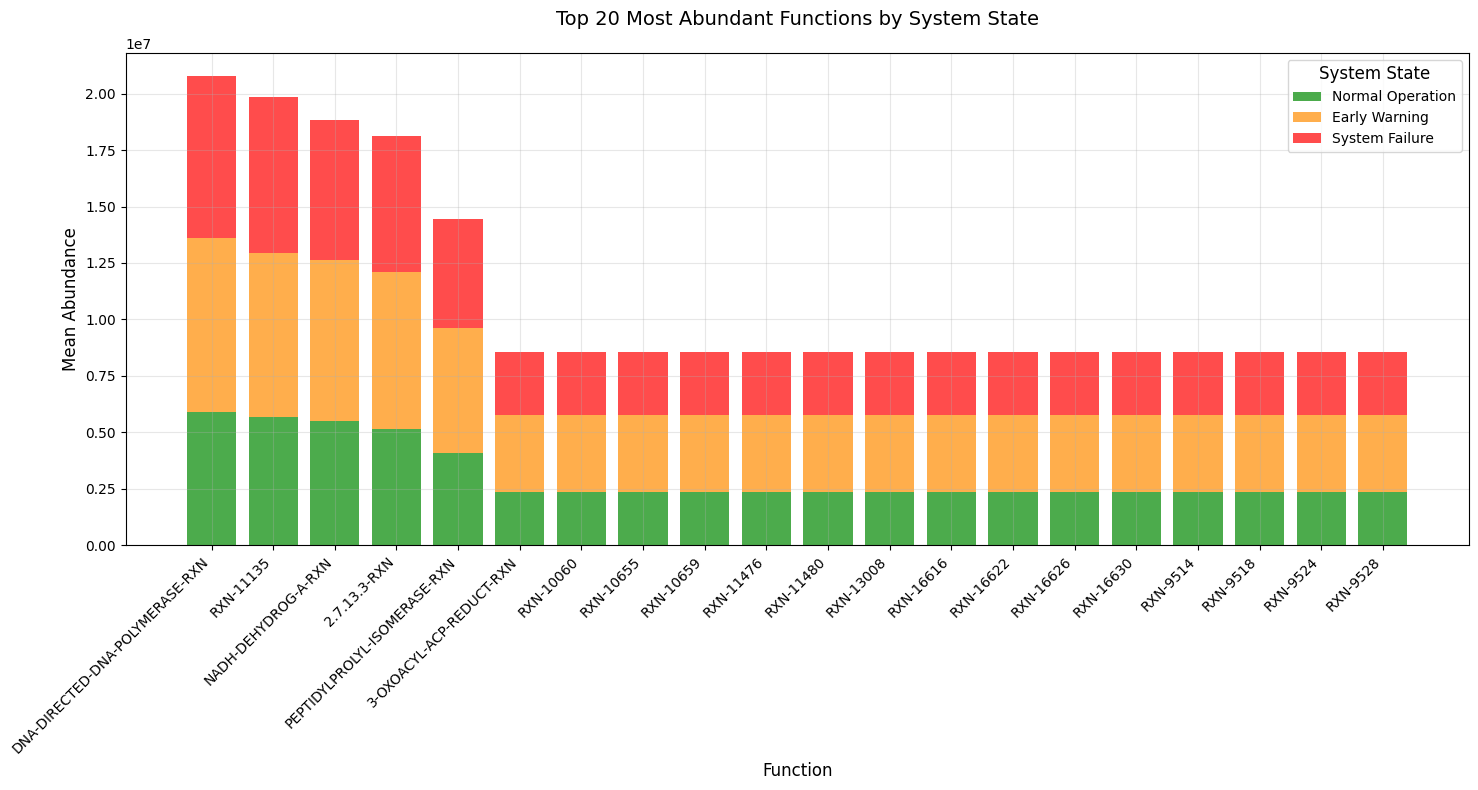

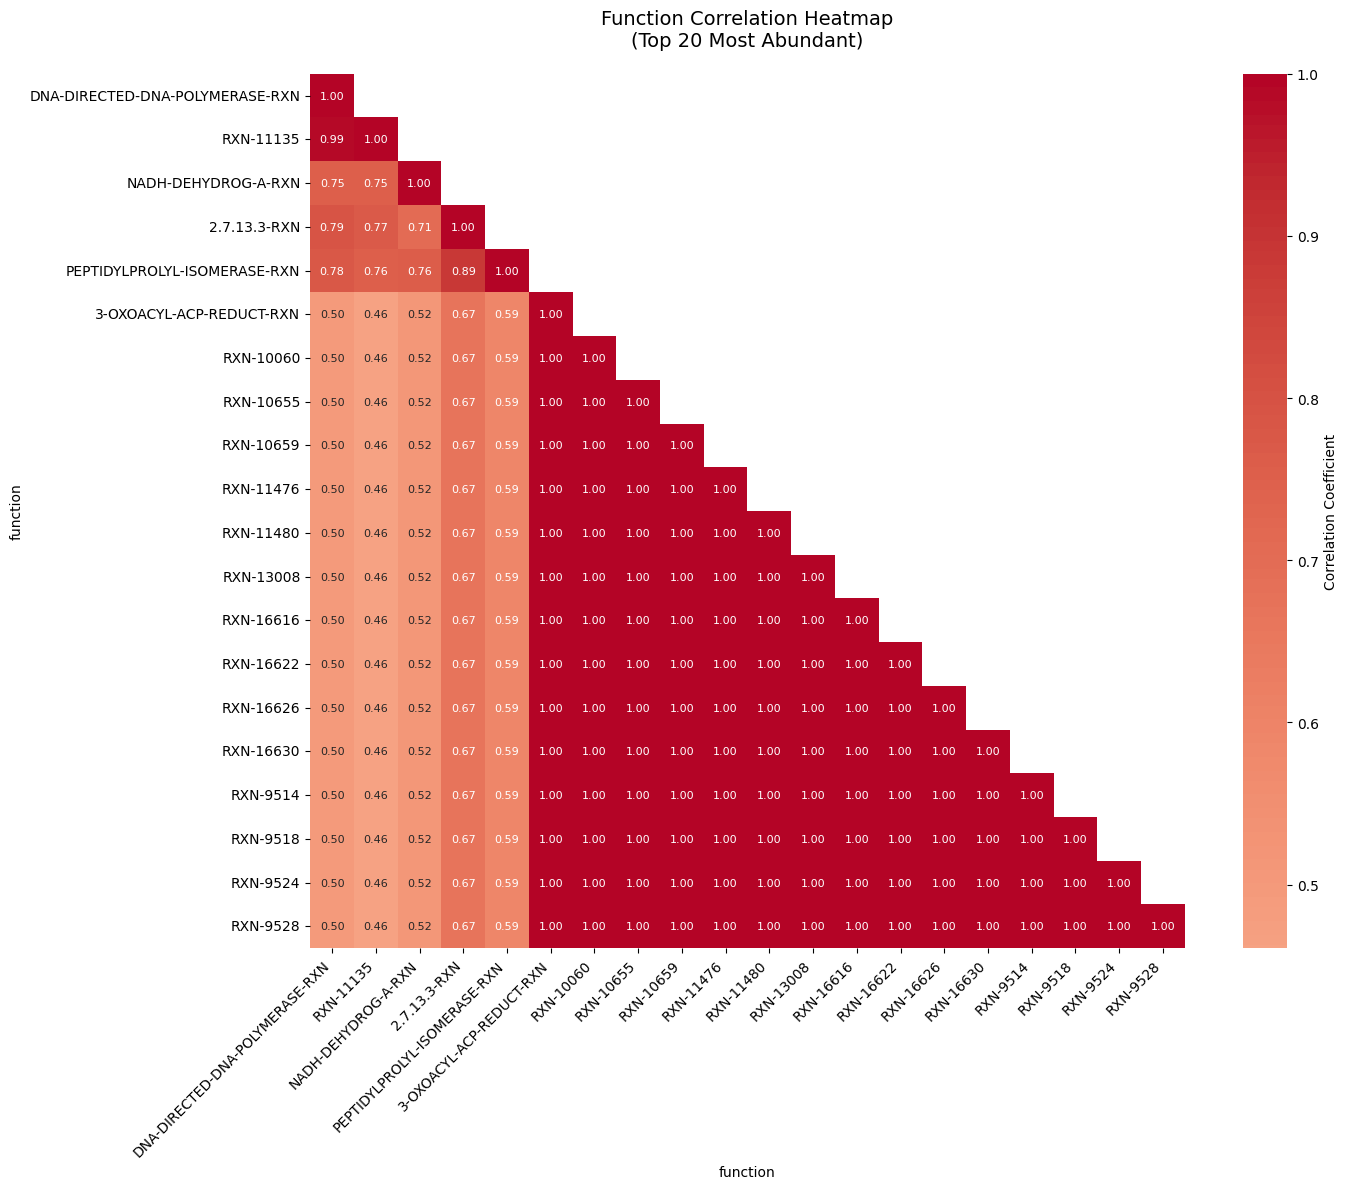

In [ ]:
def analyze_pathway_patterns(df, mean_abundances, category_dict, top_n=20):
    """
    Analyzes pathway patterns for a DataFrame with 'function' as index and 'Sites' as columns.
    This is the FINAL, CORRECTED implementation.
    """
    top_functions = mean_abundances.nlargest(top_n)
    df.index = df.index.astype(str)

    # 1. Stacked Bar Chart
    plt.figure(figsize=(15, 8))

    function_data = []
    for function in top_functions.index:
        cat_means = {}
        for cat in [1, 2, 3]:
            cat_sites = [site for site, c in category_dict.items() if c == cat]
            # Optimized site selection:
            relevant_sites = list(df.columns.intersection(cat_sites)) # More efficient intersection
            if relevant_sites:
                cat_means[cat] = df.loc[function, relevant_sites].mean()
            else:
                cat_means[cat] = 0
        function_data.append((function, cat_means))

    bottoms = np.zeros(len(top_functions))
    for cat in [1, 2, 3]:
        values = [d[1][cat] for d in function_data]
        plt.bar(range(len(top_functions)), values, bottom=bottoms,
                label=categories_labels[cat], color=category_colors[cat], alpha=0.7)
        bottoms += values

    plt.title('Top 20 Most Abundant Functions by System State', fontsize=14, pad=20)
    plt.xlabel('Function', fontsize=12)
    plt.ylabel('Mean Abundance', fontsize=12)
    plt.xticks(range(len(top_functions)), top_functions.index, rotation=45, ha='right', fontsize=10)
    plt.legend(title='System State', title_fontsize=12, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Correlation Heatmap
    plt.figure(figsize=(15, 12))
    top_data = df.loc[top_functions.index]
    # Convert all columns of top_data to numeric, coercing errors to NaN
    top_data = top_data.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any NaN values to ensure only numeric data is used for correlation
    top_data = top_data.dropna(axis=1, how='all')
    # Check if there are any columns left after dropping NaNs
    if top_data.empty:
        print("Warning: DataFrame is empty after dropping NaN columns. Skipping correlation heatmap.")
        return None  # Or return an empty DataFrame or a placeholder

    corr = top_data.T.corr()  # Transpose for function correlation

    mask = np.triu(np.ones_like(corr), k=1)  # Mask for upper triangle
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt='.2f',
                square=True, cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={'size': 8})

    plt.title('Function Correlation Heatmap\n(Top 20 Most Abundant)', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr, top_data

# Convert numeric columns to the correct data type
for col in react.columns[1:]:  # Exclude 'function' column
    try:
        react[col] = pd.to_numeric(react[col], errors='coerce') # Skip errors but convert rest
    except ValueError:
        print(f"Could not convert column '{col}' to numeric. Check its contents.")
        # Handle the error or investigate the column for non-numeric values

# Calculate the mean after type conversion
mean_abundances_react = react.mean(axis=1, numeric_only=True) # Specify only numeric in case strings remain
corr_react, top_data = analyze_pathway_patterns(react, mean_abundances_react, category_dict)

# 8. Mapping the Pathways back to the Genera

The result we obtained from the picrust pipeline contain the following dataframes, here described so it would be possible to parse. Following are the files description with the shape
| Picrust_Result | Picrust_Result | Picrust_Result | parce | parce | parce | ECcontri | ECcontri | ECcontri | ECcontri | React | React |
|---|---|---|---|---|---|---|---|---|---|---|---|
| pathway | description | Sites/abund | pathway | RXN | EC number | EC number | varios abundances | Sites | OTU | Sites/abund | Reactions |
|366,72|366,72|366,72|574,1|574,1|574,1|1491288, 9|1491288, 9|1491288, 9|1491288, 9| (2955, 71)|(2955, 71)|


In [11]:
#EC_path = Path(base_dir / "Galaxy9-[EC_T].tabular")
#EC= pd.read_csv(EC_path, sep = "\t")
# ECcontri and KOcontri files contain sample, function (EC/KO number), taxon (genus/OTU ID), and abundance metrics.
ECcontri_path =  Path(large_dir / "Galaxy26_contrib.tabular") # for VSCODE

#ECcontri_path =  Path(base_dir / "Galaxy26_contrib.tabular") # for Kaggle
ECcontri= pd.read_csv(ECcontri_path, sep = "\t")
#KOcontri_path = Path(large_dir / "Galaxy30-[KO_pred_metagenome_contrib].tabular")
#KOcontri= pd.read_csv(KOcontri_path, sep = "\t")

## 8.1. Mapping Genera to Otu

In [12]:
# Mapping the Genera to Otu for the Taxonomy assigment requeriment
def create_otu_mapping(fasta_file_final):
    """Creates a DataFrame mapping OTUs to genera from a FASTA file
    Args: fasta_file (str): Path to FASTA file
    Returns: pd.DataFrame: DataFrame with columns ['Genus', 'OTU']
    """
    mapping_data = []

    for record in SeqIO.parse(fasta_file_final, "fasta"):
        # Split description to get genus and OTU
        parts = record.description.split()
        genus = parts[0]
        otu = parts[1]  # Take first OTU number

        mapping_data.append({'Genus': genus,'OTU': otu})

    # Create DataFrame
    df = pd.DataFrame(mapping_data).sort_values('Genus')

    return df

otu_mapping = create_otu_mapping(fasta_file_final)
# Change the name of the Otus since they using taxon
otu_mapping = otu_mapping.rename(columns={"OTU" : "taxon"})

Now with the parce file where there is info for pathway, reactions and also it is the EC numbers, the EC numbers will be extracted because they are encoded inside the parce file. So that we can link the EC with the pathways in the ECcontri df. Precisely the stratified Pathway Abundance contributions (KO/EC + taxon + Taxon abundance +  others ) = KOcontri, ECcontri will be join by the taxon (which is same as the otus) with the file where is located the taxonomy Assigment = Otus + Genera Falta. Ultimately, the pathway descriptions file = Full pipipeline results(pathways + abundances) + description(human readable pathway) = Picrust_Result will also be join in order to make the visualisations, we doing that in steps.

### Map pathways to ECcontri

Map pathways (Picrust_Result) to Parce → Ensures accurate EC-pathway links.   
Map reactions (React) to Parce → Ensures correct RXN-pathway links.   
Use these mappings to update ECcontri → Assign pathways to EC numbers.  
Handle unmapped EC numbers → Keep them separate for review.  

## 8.2. Decomvoluting Parce :
separating the contents of the parsing file parce df

In [ ]:
# Initialize lists
pathways = []
all_ec_numbers = []
reactions = []

# Parse parce file
for line in parce.iloc[:, 0]:
    parts = line.split(' ', 1)
    if len(parts) == 2:
        pathway = parts[0]
        reaction_list = parts[1].strip().split()

        # Find EC numbers
        ec_nums = []
        rxns = []

        for rxn in reaction_list:
            if rxn.count('.') == 3:
                ec_part = rxn.split('-RXN')[0]
                if all(p.replace('-','').isdigit() for p in ec_part.split('.')):
                    ec_nums.append(ec_part)
                    continue
            rxns.append(rxn)

        # Pad ec_nums list to always have 7 elements
        ec_nums.extend([None] * (7 - len(ec_nums)))

        # Add to lists
        pathways.append(pathway)
        all_ec_numbers.append(ec_nums)
        reactions.append(' '.join(rxns))

# Create DataFrame
parce_reference = pd.DataFrame({
    'pathway': pathways,
    'EC1': [ecs[0] for ecs in all_ec_numbers],
    'EC2': [ecs[1] for ecs in all_ec_numbers],
    'EC3': [ecs[2] for ecs in all_ec_numbers],
    'EC4': [ecs[3] for ecs in all_ec_numbers],
    'EC5': [ecs[4] for ecs in all_ec_numbers],
    'EC6': [ecs[5] for ecs in all_ec_numbers],
    'EC7': [ecs[6] for ecs in all_ec_numbers],
    'other_reactions': reactions
})

# Display first few rows
print("First 5 rows of parce data with all EC numbers:")
print(parce_reference.head().to_string())

# Print example of a pathway with many EC numbers
print("\nExample of pathway with many EC numbers:")
print(parce_reference[parce_reference['EC7'].notna()].iloc[0].to_string())

#parce_reference.to_csv("~/MIC/2_Micro/data_picrust/EC_path_parce.csv", index=False, sep="\t")

enriched_picrust

In [ ]:
# Get list of pathways we need from Picrust_Result
picrust_pathways = set(Picrust_Result['pathway'])

# Filter parce_reference to only include needed pathways
parced_picrust = parce_reference[parce_reference['pathway'].isin(picrust_pathways)]

# Print statistics
print("Matching Statistics:")
print(f"Total pathways in Picrust_Result: {len(picrust_pathways)}")
print(f"Matched pathways from parced_picrust: {len(parced_picrust)}")

# Show some examples of the matched data
print("\nFirst few matched pathways:")
print(parced_picrust.head().to_string())

# Check if we missed any pathways
missing_pathways = picrust_pathways - set(parced_picrust['pathway'])
if missing_pathways:
    print("\nWarning: Some Picrust pathways not found in parce:")
    print(list(missing_pathways)[:5])  # Show first 5 missing pathways if any
#parced_picrust.to_csv("~/MIC/2_Micro/data_picrust/parced_picrust.csv", index=False, sep="\t")

In [ ]:
parce.head()

This way of mapping from parce df was no effective, the pathways and EC in parce are no all the ones are on ECcontri. So it was decided to map it from ECcontri directly putting the pathways into the df from Picrust_Result, so just put the two columns description and pathways inside the ECcontri by the column Site, instead that from the column function aka EC numbers.

## 8.3. Map Econtri to pathways

We can no directly map the description and the pathway from Picrust_Result into ECcontri because each site can have several pathways, so we reshaping the Picrust_Result to long format and so that each row corresponds to a pathway for a given site. It is no possible to do this on a go using the whole 1491288 rows on ECcontri, so it would have to be done on agreggated data, as suggested by McKinney, 2010.
Source: McKinney, W. (2010). Data Structures for Statistical Computing in Python. Retrieved from https://pandas.pydata.org/


In [13]:
# Reshape Picrust_Result to long format: each row now corresponds to a pathway for a given site
picrust_long = Picrust_Result.melt(id_vars=['pathway', 'description'],
                                   var_name='sample',
                                   value_name='abundance')

# Filter out rows where the abundance is 0 (assuming that's what you mean by "pathway present")
picrust_long = picrust_long[picrust_long['abundance'] > 0]

# Aggregate pathway info per site
mapping = picrust_long.groupby('sample').agg({
    'pathway': lambda x: list(x),
    'description': lambda x: list(x)
}).reset_index()

# Merge the aggregated mapping with ECcontri
ECcontri_agg_site = pd.merge(ECcontri, mapping, on='sample', how='left')

In [ ]:
ECcontri_agg_site.head()

In [14]:
 # Add genus information from otu_mapping
ECcontri_agg_site['taxon'] = ECcontri_agg_site['taxon'].astype(str)
otu_mapping['taxon'] = otu_mapping['taxon'].astype(str)

ECcontri_otu= pd.merge(ECcontri_agg_site, otu_mapping, on='taxon', how='left', validate='m:1')

unmapped = ECcontri_otu['Genus'].isna().sum()
if unmapped > 0:
    print(f"Warning: {unmapped} rows could not be mapped to genera")
# Rename columns: here "description" becomes "pathway" and "pathway" becomes "npath"
ECcontri_otu  = ECcontri_otu.rename(columns={"sample":"Sites", "function": "EC", "taxon": "OTU", "description":"pathway", "pathway":"npath",
                                     "taxon_abun": "abund_raw", "taxon_function_abun": "abund_contri", "taxon_rel_abun": "rel_abund_raw",
                                       "taxon_rel_function_abun": "rel_abund_contri", "norm_taxon_function_contrib" :"norm_abund_contri", "genome_function_count":"genome_EC_count"})
# Organize columns in logical groups
cols_order = ['Sites', 'Genus', 'OTU', 'EC', # Identification columns
              'npath', 'pathway', # Pathway information
              'abund_raw', 'rel_abund_raw', # Raw abundance metrics
              'genome_EC_count', 'abund_contri', 'rel_abund_contri', 'norm_abund_contri'] # Contribution metrics
# Reorder columns, takes like 4 minutes on this slow laptop
ECcontri_otu = ECcontri_otu[cols_order]

ECcontri_otu is a comprehensive dataframe that combines site locations, taxonomic information (genera and OTUs), enzyme classifications (ECs), and pathways (code for pathway (npath) and description (pathway)). The associated abundance metrics belong to the original ECcontri. The abundance metrics include:
abund_raw: The original count of each organism (OTU) at each site
rel_abund_raw: The relative abundance of each organism at each site, expressed as a proportion of total counts
genome_function_count represents the predicted number of copies of a particular EC number (enzyme) in an organism's genome. This prediction comes from PICRUSt's hidden-state prediction process, which infers gene family abundances for each organism based on its phylogenetic placement relative to reference genomes
abund_contri: The contribution of each organism to a specific enzyme function, calculated by multiplying the raw abundance by the number of copies of that enzyme in the organism's genome
rel_abund_contri: The relative contribution of each organism to the enzyme function, accounting for both abundance and genome copy number
norm_abund_contri: The normalized contribution metric that allows comparison across different sites and functions

In [ ]:
'''# Analyze genome_function_count
print("Genome function count statistics:")
print("\nOverall statistics:")
print(ECcontri_otu['genome_EC_count'].describe())

# Look at distribution by EC number
print("\nExample EC numbers and their genome counts:")
ec_counts = ECcontri_otu.groupby('EC')['genome_EC_count'].agg(['unique', 'mean', 'max']).head()
print(ec_counts)

# Check if genome_function_count is consistent for each OTU-EC pair
print("\nCheck if genome_EC_count is consistent for OTU-EC combinations:")
consistency_check = ECcontri_otu.groupby(['OTU', 'EC'])['genome_EC_count'].nunique()
inconsistent = consistency_check[consistency_check > 1]
if len(inconsistent) > 0:
    print(f"Found {len(inconsistent)} OTU-EC pairs with inconsistent genome counts")
else:
    print("Genome counts are consistent for all OTU-EC pairs")

# Explain the metrics in the dataframe
print("\nDataframe Components:")
print("1. Abundance Metrics:")
print("   - abund_raw: Raw abundance of each organism in each site")
print("   - abund_contri: Organism's abundance contribution to function/pathway")
print("   - rel_abund_raw: Original relative abundance")
print("   - rel_abund_contri: Relative abundance contribution to pathway")
print("   - norm_abund_contri: Normalized abundance contribution")
print("\n2. Genome Function Count:")
print("   Number of copies of each EC (enzyme) in organism's genome")'''

Genome function count statistics:

Overall statistics:
count    1.491288e+06
mean     1.390277e+00
std      1.071974e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+01
Name: genome_EC_count, dtype: float64

Example EC numbers and their genome counts:
                                    unique      mean  max
EC                                                       
EC:1.1.1.1              [3, 2, 1, 5, 4, 8]  2.310375    8
EC:1.1.1.100  [8, 5, 2, 3, 4, 9, 10, 6, 1]  4.237317   10
EC:1.1.1.102                           [1]  1.000000    1
EC:1.1.1.103                           [1]  1.000000    1
EC:1.1.1.105                           [1]  1.000000    1

Check if genome_EC_count is consistent for OTU-EC combinations:
Genome counts are consistent for all OTU-EC pairs

Dataframe Components:
1. Abundance Metrics:
   - abund_raw: Raw abundance of each organism in each site
   - abund_contri: Organism's abundance contribution to function/pathway
   - rel_abund_raw: Original relative abundance
   - rel_abund_contri: Relative abundance contribution to pathway
   - norm_abund_contri: Normalized abundance contribution

2. Genome Function Count:
   Number of copies of each EC (enzyme) in organism's genome

Analysis of genome_function_count(genome_EC_count) shows that most organisms typically have just one copy of any given enzyme (EC number) in their genome, with 75% of all cases showing a single copy. However, there is notable variation, with some organisms having up to 10 copies of certain enzymes. The average across all cases is 1.4 copies per enzyme per organism.
Some enzymes show more variation than others. For example:

EC:1.1.1.1 varies from 1 to 8 copies across different organisms
EC:1.1.1.100 shows the widest range, from 1 to 10 copies
Many enzymes (like EC:1.1.1.102, 103, 105) consistently appear as single copies

Importantly, the copy number is consistent for each organism-enzyme combination across all sites, indicating this is a stable genomic characteristic.

_____________________

Pathway Mapping Analysis

There were identified a discrepancy between EC predictions and pathway abundances. Found 61 pathways with EC number evidence that were not included in final predictions. Total number of reference pathways: 574 (from MetaCyc), total pathways in final predictions: 366, example missing pathway: PWY-6486 supported by EC:4.2.1.41

Implications
This finding suggests that the pathway prediction pipeline might be filtering out potentially relevant pathways despite having supporting EC evidence. This could impact the biological interpretation of the functional profiles and warrants further investigation.
So in this study we mapped the pathways dataframe directly to the parce file and in doing so we have also the reaction information, avoiding the discrepancy with the Picrust_Result missing pathways.

_____________________

Now ECcontri_otu has several rows and columns providing information of the EC contribution to the metrics to each enzime aka EC number to the sites, genera combination, however the pathways are from origin link to most of the sites. This is perhaps because the methos infwee dunxriona bAWS ON XOMON sets of reference genomes.  Then, same environment in this case heating and cooling water systems poses similar organisms with similar pathways, the difference being on the abundance. So in order for this data to be usable, it is necesary to parse the EC into human readable information from a external enzyme databases to retrieve functional information about an EC number. Common resources include:

UniProt: query UniProt’s REST API to get enzyme details by searching with the EC number.
ExPASy Enzyme Database: Provides enzyme information based on EC numbers.
BRENDA: A comprehensive enzyme database that can be queried either via its web interface or programmatically (e.g., using the bioservices Python package). Following script creates an EnzymeRetriever class that handles API requests to UniProt, processes unique EC numbers to avoid duplicate requests
Adds protein names, functions, and UniProt IDs to ECcontri_otu df and includes rate limiting to avoid API restrictions.

## 8.4 Retrieving EC from Uniprot Locally

In [ ]:
import pandas as pd
import requests
import time
import json
from pathlib import Path

class BatchEnzymeRetriever:
    def __init__(self, batch_size=50, save_every=10):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        self.batch_size = batch_size
        self.save_every = save_every
        self.results_file = 'uniprot_results.csv'
        self.progress_file = 'retrieval_progress.json'
        self.current_position = 0
        self.load_progress()

    def load_progress(self):
        """Load progress from previous run"""
        if Path(self.progress_file).exists():
            with open(self.progress_file, 'r') as f:
                self.current_position = json.load(f)['position']
            print(f"Resuming from position {self.current_position}")
        else:
            print("Starting new retrieval process")

    def save_progress(self):
        """Save current progress"""
        with open(self.progress_file, 'w') as f:
            json.dump({'position': self.current_position}, f)

    def get_uniprot_info(self, ec: str, organism: str) -> dict:
        """Get UniProt information for a specific EC-organism pair"""
        query = f"{ec} {organism}"

        params = {
            'query': query,
            'format': 'tsv',
            'fields': 'id,ec,organism_name,protein_name',
            'size': 10
        }

        try:
            response = requests.get(self.uniprot_api, params=params)
            response.raise_for_status()

            # Parse results
            lines = response.text.strip().split('\n')
            if len(lines) < 2:
                return None

            # Process results to find best match
            best_match = None
            best_score = -float('inf')

            for line in lines[1:]:  # Skip header
                parts = line.split('\t')
                if len(parts) < 4:
                    continue

                entry_id, ec_numbers, org_name, protein_name = parts

                # Calculate score based on organism name simplicity
                score = 0
                if organism.lower() in org_name.lower():
                    score += 100
                    if org_name.lower().endswith(' sp') or org_name.lower().endswith(' sp.'):
                        score += 200
                    if any(char.isdigit() for char in org_name):
                        score -= 100

                    # Check EC number match
                    if ec.replace('EC:', '') in ec_numbers.split('; '):
                        score += 150

                        if score > best_score:
                            best_score = score
                            best_match = {
                                'uniprot_id': entry_id,
                                'ec_number': ec,
                                'protein_name': protein_name,
                                'organism': org_name,
                                'score': score
                            }

            return best_match

        except requests.exceptions.RequestException as e:
            print(f"Error retrieving data for {ec} - {organism}: {e}")
            time.sleep(5)
            return None

    def process_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process DataFrame in batches, saving progress"""

        # Load existing results if any
        results_df = pd.DataFrame()
        if Path(self.results_file).exists():
            results_df = pd.read_csv(self.results_file)
            print(f"Loaded {len(results_df)} existing results")

        # Get unique EC-organism pairs starting from current position
        pairs = df[['EC', 'Genus']].drop_duplicates()
        pairs = pairs.iloc[self.current_position:]

        print(f"Processing {len(pairs)} unique EC-organism pairs")

        for batch_start in range(0, len(pairs), self.batch_size):
            batch = pairs.iloc[batch_start:batch_start + self.batch_size]
            batch_results = []

            print(f"\nProcessing batch {batch_start//self.batch_size + 1}")

            for _, row in batch.iterrows():
                print(f"Querying {row['EC']} - {row['Genus']}")
                result = self.get_uniprot_info(row['EC'], row['Genus'])

                if result:
                    batch_results.append(result)
                time.sleep(1)  # Rate limiting

            # Add batch results to DataFrame
            if batch_results:
                batch_df = pd.DataFrame(batch_results)
                results_df = pd.concat([results_df, batch_df], ignore_index=True)

                # Save periodically
                if (batch_start//self.batch_size) % self.save_every == 0:
                    results_df.to_csv(self.results_file, index=False)
                    self.current_position += len(batch)
                    self.save_progress()
                    print(f"Saved progress at position {self.current_position}")

        # Final save
        if not results_df.empty:
            results_df.to_csv(self.results_file, index=False)
        return results_df

def process_enzymes(input_data, batch_size: int = 50):
    """Main function to process enzyme data"""
    # Handle both DataFrame and file path inputs
    if isinstance(input_data, str):
        df = pd.read_csv(input_data)
        print(f"Loaded {len(df)} rows from {input_data}")
    elif isinstance(input_data, pd.DataFrame):
        df = input_data
        print(f"Processing DataFrame with {len(df)} rows")
    else:
        raise ValueError("Input must be either a file path or a pandas DataFrame")

    # Initialize retriever
    retriever = BatchEnzymeRetriever(batch_size=batch_size)

    # Process data
    results = retriever.process_dataframe(df)
    print("\nProcessing complete!")
    print(f"Results saved to {retriever.results_file}")
    return results

In [ ]:
'''
#  DataFrame loaded:
retriever = BatchEnzymeRetriever(batch_size=50)
Picrust_Econtri = retriever.process_dataframe(ECcontri_otu)'''

## 8.5. Colab
Made in colab for resource posibility.

original colab code

In [ ]:
class ColabEnzymeRetriever:
    def __init__(self, batch_size=100, save_every=5):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        self.batch_size = batch_size
        self.save_every = save_every
        self.results_file = 'uniprot_results.csv'
        self.existing_results = None

    def load_existing_results(self, file_path):
        """Load and validate existing results"""
        self.existing_results = pd.read_csv(file_path)
        print(f"Loaded {len(self.existing_results)} existing results")
        return set(zip(self.existing_results['ec_number'],
                      [org.split()[0] for org in self.existing_results['organism']]))

    def get_uniprot_info(self, ec: str, organism: str) -> dict:
        """Get UniProt information for a specific EC-organism pair"""
        query = f"{ec} {organism}"

        params = {
            'query': query,
            'format': 'tsv',
            'fields': 'id,ec,organism_name,protein_name',
            'size': 10
        }

        try:
            response = requests.get(self.uniprot_api, params=params)
            response.raise_for_status()
            time.sleep(0.5)  # Reduced sleep time for Colab

            lines = response.text.strip().split('\n')
            if len(lines) < 2:
                return None

            best_match = None
            best_score = -float('inf')

            for line in lines[1:]:
                parts = line.split('\t')
                if len(parts) < 4:
                    continue

                entry_id, ec_numbers, org_name, protein_name = parts

                score = 0
                if organism.lower() in org_name.lower():
                    score += 100
                    if org_name.lower().endswith(' sp') or org_name.lower().endswith(' sp.'):
                        score += 200
                    if any(char.isdigit() for char in org_name):
                        score -= 100

                    if ec.replace('EC:', '') in ec_numbers.split('; '):
                        score += 150

                        if score > best_score:
                            best_score = score
                            best_match = {
                                'uniprot_id': entry_id,
                                'ec_number': ec,
                                'protein_name': protein_name,
                                'organism': org_name,
                                'score': score
                            }

            return best_match

        except requests.exceptions.RequestException as e:
            print(f"Error retrieving data for {ec} - {organism}: {e}")
            time.sleep(2)
            return None

    def process_remaining_pairs(self, unique_pairs: pd.DataFrame, processed_pairs: set) -> pd.DataFrame:
        """Process only the pairs that haven't been processed yet"""
        results = []
        pairs_to_process = []

        # Get unprocessed pairs
        for _, row in unique_pairs.iterrows():
            if (row['EC'], row['Genus']) not in processed_pairs:
                pairs_to_process.append((row['EC'], row['Genus']))

        pairs_df = pd.DataFrame(pairs_to_process, columns=['EC', 'Genus'])
        total_pairs = len(pairs_df)

        print(f"\nTotal pairs to process: {total_pairs}")

        if total_pairs == 0:
            print("No new pairs to process!")
            return self.existing_results

        for batch_start in range(0, total_pairs, self.batch_size):
            batch = pairs_df.iloc[batch_start:batch_start + self.batch_size]
            batch_results = []

            print(f"\nProcessing batch {batch_start//self.batch_size + 1} of {total_pairs//self.batch_size + 1}")
            print(f"Progress: {batch_start}/{total_pairs} pairs ({(batch_start/total_pairs)*100:.1f}%)")

            current_ec = None
            for _, row in batch.iterrows():
                if current_ec != row['EC']:
                    current_ec = row['EC']
                    print(f"\nProcessing EC number: {current_ec}")

                result = self.get_uniprot_info(row['EC'], row['Genus'])
                if result:
                    batch_results.append(result)

            if batch_results:
                results.extend(batch_results)

                # Save progress by combining with existing results
                if (batch_start//self.batch_size) % self.save_every == 0:
                    combined_results = pd.concat([self.existing_results, pd.DataFrame(results)], ignore_index=True)
                    combined_results.to_csv(self.results_file, index=False)
                    print(f"Saved {len(combined_results)} total results to file")

        # Combine final results
        final_results = pd.concat([self.existing_results, pd.DataFrame(results)], ignore_index=True)
        final_results.to_csv(self.results_file, index=False)
        return final_results

# Main processing function
def continue_enzyme_retrieval(data_file: str, existing_results_file: str):
    """Main function to continue enzyme data retrieval"""
    # Initialize retriever
    retriever = ColabEnzymeRetriever(batch_size=100)

    # Load existing results
    processed_pairs = retriever.load_existing_results(existing_results_file)

    # Load and process data
    df = pd.read_csv(data_file)
    unique_pairs = df[['EC', 'Genus']].drop_duplicates()
    print(f"Total unique pairs in data: {len(unique_pairs)}")
    print(f"Already processed pairs: {len(processed_pairs)}")

    # Process remaining pairs
    results_df = retriever.process_remaining_pairs(unique_pairs, processed_pairs)

    # Save and download final results
    results_df.to_csv('uniprot_results_final.csv', index=False)
    files.download('uniprot_results_final.csv')

    return results_df

In [ ]:
# Usage (after uploading files to Colab), ECcontri_otu was made in colab because it was too big to upload after transformed
# results = continue_enzyme_retrieval('ECcontri_otu', 'uniprot_results.csv')

have to be modify after first run

In [ ]:
import pandas as pd
import requests
import time
from pathlib import Path
import logging
from typing import Set, Tuple, Optional
import json

class ColabEnzymeRetriever:
    def __init__(self, batch_size=100, save_every=5):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        self.batch_size = batch_size
        self.save_every = save_every
        self.results_file = Path('uniprot_results.tsv')
        self.state_file = Path('retrieval_state.json')
        self.processed_pairs: Set[Tuple[str, str]] = set()
        self.existing_results = None
        self.logger = logging.getLogger(__name__)
        self.logger.setLevel(logging.INFO)

        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def load_existing_results(self, file_path: Path) -> pd.DataFrame:
        """Load and validate existing results"""
        if file_path.exists():
            try:
                self.existing_results = pd.read_csv(file_path, sep='\t')
                self.logger.info(f"Loaded {len(self.existing_results)} existing results")

                # Build set of processed pairs
                self.processed_pairs = set()
                for _, row in self.existing_results.iterrows():
                    if pd.notna(row['ec_number']) and pd.notna(row['organism']):
                        ec_num = str(row['ec_number']).strip()
                        org = str(row['organism']).split()[0].strip()
                        self.processed_pairs.add((ec_num, org))

                return self.existing_results
            except Exception as e:
                self.logger.error(f"Error loading results file: {e}")
                self.existing_results = pd.DataFrame(
                    columns=['uniprot_id', 'ec_number', 'protein_name', 'organism', 'score']
                )
                return self.existing_results

        self.existing_results = pd.DataFrame(
            columns=['uniprot_id', 'ec_number', 'protein_name', 'organism', 'score']
        )
        return self.existing_results

    def get_uniprot_info(self, ec: str, organism: str) -> Optional[dict]:
        """Get UniProt information for a specific EC-organism pair"""
        if (ec, organism) in self.processed_pairs:
            return None

        query = f'({ec}) AND (organism_name:"{organism}*")'
        params = {
            'query': query,
            'format': 'tsv',
            'fields': 'id,ec,protein_name,organism_name',
            'size': 10
        }

        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = requests.get(self.uniprot_api, params=params)
                response.raise_for_status()
                time.sleep(0.5)

                lines = response.text.strip().split('\n')
                if len(lines) < 2:
                    return None

                best_match = None
                best_score = -float('inf')

                for line in lines[1:]:
                    parts = line.split('\t')
                    if len(parts) < 4:
                        continue

                    uniprot_id, ec_numbers, protein_name, organism_name = parts

                score = 0
                if organism_name and isinstance(organism_name, str):
                    name_parts = organism_name.split()
                    genus = name_parts[0] if name_parts else ""

                    # Exact genus match gets highest score
                    if genus.lower() == organism.lower():
                        score += 500
                        # Prefer entries with just the genus name
                        if len(name_parts) == 1:
                            score += 300
                        # Heavily penalize strain designations or subspecies
                        elif len(name_parts) > 2 or any(char.isdigit() for char in organism_name):
                            score -= 400

                    if score > -float('inf'):
                        if ec.replace('EC:', '') in ec_numbers.split('; '):
                            score += 150

                            if score > best_score:
                                best_score = score
                                best_match = {
                                    'uniprot_id': uniprot_id,
                                    'ec_number': ec,
                                    'protein_name': protein_name,
                                    'organism': organism_name,
                                    'score': score
                                }

                return best_match if best_match else None

            except requests.exceptions.RequestException as e:
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                    continue
                self.logger.error(f"Error fetching data from UniProt: {e}")
                return None

    def process_remaining_pairs(self, unique_pairs: pd.DataFrame, start_ec: str) -> pd.DataFrame:
        """Process remaining pairs with enforced starting point"""
        # Ensure EC format consistency
        if not start_ec.startswith('EC:'):
            start_ec = f"EC:{start_ec.replace('EC:', '')}"

        # Sort and filter pairs
        unique_pairs = unique_pairs.sort_values(['EC', 'Genus']).reset_index(drop=True)
        unique_pairs = unique_pairs[unique_pairs['EC'] >= start_ec].reset_index(drop=True)

        if len(unique_pairs) == 0:
            self.logger.warning(f"No EC numbers found after {start_ec}")
            return self.existing_results

        self.logger.info(f"Starting processing from {unique_pairs.iloc[0]['EC']}")
        total_pairs = len(unique_pairs)

        results = []
        for idx in range(0, total_pairs, self.batch_size):
            batch = unique_pairs.iloc[idx:idx + self.batch_size]
            batch_results = []

            self.logger.info(f"\nProcessing batch {idx//self.batch_size + 1} of {total_pairs//self.batch_size + 1}")
            self.logger.info(f"Progress: {idx}/{total_pairs} pairs ({(idx/total_pairs)*100:.1f}%)")

            current_ec = None
            for _, row in batch.iterrows():
                if current_ec != row['EC']:
                    current_ec = row['EC']
                    self.logger.info(f"\nProcessing EC number: {current_ec}")

                if (row['EC'], row['Genus']) not in self.processed_pairs:
                    result = self.get_uniprot_info(row['EC'], row['Genus'])
                    if result:
                        batch_results.append(result)
                        self.processed_pairs.add((row['EC'], row['Genus']))

            if batch_results:
                results.extend(batch_results)

                # Save progress periodically
                if (idx//self.batch_size) % self.save_every == 0:
                    combined_results = pd.concat(
                        [self.existing_results, pd.DataFrame(results)],
                        ignore_index=True
                    )
                    combined_results.to_csv(self.results_file, sep='\t', index=False)
                    self.logger.info(f"Saved {len(combined_results)} total results to file")

        # Final save
        final_results = pd.concat(
            [self.existing_results, pd.DataFrame(results)],
            ignore_index=True
        )
        final_results.to_csv(self.results_file, sep='\t', index=False)

        return final_results

def continue_enzyme_retrieval(unique_pairs: pd.DataFrame, existing_results_file: Path, start_ec: str):
    """Main function to continue enzyme data retrieval"""
    retriever = ColabEnzymeRetriever(batch_size=100)

    # Load existing results
    retriever.load_existing_results(existing_results_file)

    # Ensure input data is properly formatted
    if isinstance(unique_pairs, str):
        unique_pairs = pd.read_csv(unique_pairs, sep='\t')
    elif isinstance(unique_pairs, pd.DataFrame):
        unique_pairs = unique_pairs.copy()
    else:
        raise ValueError("Input must be either a file path or a pandas DataFrame")

    # Validate and prepare input data
    required_columns = ['EC', 'Genus']
    if not all(col in unique_pairs.columns for col in required_columns):
        raise ValueError(f"Input data must contain columns: {required_columns}")

    unique_pairs['EC'] = unique_pairs['EC'].astype(str).apply(lambda x: f"EC:{x.replace('EC:', '')}")
    unique_pairs['Genus'] = unique_pairs['Genus'].astype(str).str.strip()
    unique_pairs = unique_pairs[['EC', 'Genus']].drop_duplicates()

    # Process remaining pairs
    results_df = retriever.process_remaining_pairs(unique_pairs, start_ec)

    # Save final results
    final_path = Path('uniprot_results_final.tsv')
    results_df.to_csv(final_path, sep='\t', index=False)

    return results_df

In [ ]:
'''uniprot_results_path = Path(base_dir '/uniprot_results.tsv')
# Usage (after uploading files to Colab), ECcontri_otu was made in colab because it was too big to upload after transformed
results = continue_enzyme_retrieval(ECcontri_otu, uniprot_results_path, start_ec="x.3.1.12" )'''

## 8.6. Cleaning and Preparing Retrieved Data to integrate to ECContri

In [15]:
df_1_path = Path(base_dir / "uniprot_1_4_sorted.tsv") # First file retrieved on first run 4 am
df_2_path = Path(base_dir / "uniprot_2_1.38_sorted.tsv") # Same file retrieven when corrupted around 1:38 following day
df_3_path = Path(base_dir / "uniprot_3_sorted.tsv") # Rerun done trying to get following EC numbers
df_4_path = Path(base_dir / "uniprot_4_missing_sorted.tsv") # Final run in missing data

df_1 = pd.read_csv(df_1_path, sep='\t')
df_2 = pd.read_csv(df_2_path, sep='\t')
df_3 = pd.read_csv(df_3_path, sep='\t')
df_4 = pd.read_csv(df_4_path, sep='\t')
print(len(df_1), len(df_2), len(df_3), len(df_4))

37015 39042 9064 2827


In [16]:
# extract EC and Genus from the Retrieved files, so I need to join them first
retrieved = pd.concat([df_1, df_2, df_3, df_4], axis = 0)
unique_pairs = ECcontri_otu[['EC', 'Genus']].drop_duplicates()
len(unique_pairs)

51152

In [17]:
retrieved.head(20)

,uniprot_id,ec_number,protein_name,organism,score
0,TERPD_PSESP,EC:1.1.1.1,Probable alcohol dehydrogenase (EC 1.1.1.1),Pseudomonas sp,450
1,A0A9D7J4U7_9ACTN,EC:1.1.1.1,alcohol dehydrogenase (EC 1.1.1.1),Tessaracoccus sp,450
2,A0A212K4D7_9BACT,EC:1.1.1.1,Fe-containing alcohol dehydrogenase (EC 1.1.1.1),uncultured Desulfovibrio sp,450
3,A0AA95FFE5_9FLAO,EC:1.1.1.1,Iron-containing alcohol dehydrogenase (EC 1.1....,Chryseobacterium sp,450
4,A0A4D7AY54_9HYPH,EC:1.1.1.1,alcohol dehydrogenase (EC 1.1.1.1),Phreatobacter stygius,250
5,A0A949KZ85_9BACT,EC:1.1.1.1,Iron-containing alcohol dehydrogenase (EC 1.1....,Desulfomicrobium sp,450
6,A0A355D6P5_CLOSP,EC:1.1.1.1,alcohol dehydrogenase (EC 1.1.1.1),Clostridium sp,450
7,A0A7W6D7B0_9HYPH,EC:1.1.1.1,Alcohol dehydrogenase (EC 1.1.1.1),Mycoplana azooxidifex,250
8,A0A1H7Y3R7_9BACT,EC:1.1.1.1,alcohol dehydrogenase (EC 1.1.1.1),Syntrophus gentianae,250
9,D2MP74_9FIRM,EC:1.1.1.1,"Alcohol dehydrogenase, iron-dependent (EC 1.1....",Bulleidia extructa W1219,150


Extracting the Genus from the retrieved_pairs

In [18]:
# Function to extract the Genus from the organism str
def extract_genus(organism_str):
    # Assumes Genus is the first word that starts with an uppercase letter.
    match = re.search(r'([A-Z][a-z]+)', organism_str)
    return match.group(1) if match else None
# Creating a Genus column in the retrieved dataframe.
retrieved['Genus'] = retrieved['organism'].astype(str).apply(extract_genus)

# if there are duplicates, we want the best entry based on score:
retrieved_unique = retrieved.sort_values('score', ascending=False)\
                            .drop_duplicates(subset=['ec_number', 'Genus'])

In [19]:
# Merging using a left join on the two keys (EC_number and Genus). Plus an indicator of missing data.
ECcontri_Uniprot  = pd.merge(
    ECcontri_otu,
    retrieved_unique[['ec_number', 'Genus', 'protein_name', 'score', 'uniprot_id']],
    left_on=['EC', 'Genus'],
    right_on=['ec_number', 'Genus'],
    how='left',
    suffixes=('', '_retr')
)
print(ECcontri_Uniprot.shape) # Very slow 1 minute, can kill the kernel

(1491288, 16)


In [20]:
ECcontri_Uniprot = ECcontri_Uniprot.drop(columns = ["OTU",	"EC",	"npath", "ec_number",	"score",	"uniprot_id"])

ECcontri_uniprot_info is the final df mixed and is keep for reference only purposes. With the missing unique df I will retrive again the rest of the missing values

In [21]:
'''#Rows with no match from retrieved_unique will have '_merge' value of 'left_only'
merged_unique = pd.merge(
    unique_pairs,
    retrieved_unique,
    left_on=['EC', 'Genus'],
    right_on=['ec_number', 'Genus'],
    how='left',
    indicator=True
)

# Filter unique pairs missing from retrieved data
ECcontri_missing = merged_unique[merged_unique['_merge'] == 'left_only']
print("Missing unique pairs count:", ECcontri_missing.shape[0])
ECcontri_missing = ECcontri_missing[["EC", "Genus"]]
file_path = os.path.join(output_dir, "ECcontri_missing.tsv")
ECcontri_missing.to_csv(file_path, sep='\t', index=False)'''

'#Rows with no match from retrieved_unique will have \'_merge\' value of \'left_only\'\nmerged_unique = pd.merge(\n    unique_pairs,\n    retrieved_unique,\n    left_on=[\'EC\', \'Genus\'],\n    right_on=[\'ec_number\', \'Genus\'],\n    how=\'left\',\n    indicator=True\n)\n\n# Filter unique pairs missing from retrieved data\nECcontri_missing = merged_unique[merged_unique[\'_merge\'] == \'left_only\']\nprint("Missing unique pairs count:", ECcontri_missing.shape[0])\nECcontri_missing = ECcontri_missing[["EC", "Genus"]]\nfile_path = os.path.join(output_dir, "ECcontri_missing.tsv")\nECcontri_missing.to_csv(file_path, sep=\'\t\', index=False)'

### Cleaning anc collecting garbage

In [22]:
#del results_EPA
#del results_SEPP
del record
del react
del reaction_list
del consistency_check
del mean_abundances_react
del EC

NameError: name 'results_EPA' is not defined

In [23]:
del picrust_long
del retrieved
del retrieved_unique
del unique_pairs
del df_1
del df_2
del df_3
del df_4
del ECcontri
del ECcontri_agg_site
del ECcontri_otu

In [24]:
import gc
gc.collect()

7361

### Data Retrieval Completion Note
After multiple retrieval attempts, 12,656 pairs remain unmapped out of approximately 1,500,000 total rows (0.84%). Given this small percentage and the diminishing returns from further retrieval attempts, we concluded that this level of completeness is acceptable for analysis.

## 8.7. Making an Integrated Picrust Result df: genera_matrix
the data is found now in a long format, for the next plotting we will be grouping it and making it onto a new df. We can group by Site and Genus (or even by protein_name) to look at the overall enzymatic contributions and how they correlate with the risk categories. The pathways information is actually very dense, it has some entries upto 300 pathway for site. So in this way we do a pathway chart but wont be bringing it to the next visualisations. The aim being to identify which genera or enzymes are most abundant in high-risk sites, assess if the presence of certain metal-specific enzymes (like Fe-dependent dehydrogenases) is linked to corrosion risk, ultimately potentially filter out common background organisms that are less relevant and perhaps just endemic part of the water systems in general and no specific to corrosion. So a table will be created with following information
|Sites|Genus|protein_name|norm_abund_contri|*Category|
|--|--|--|--|--|

*where category will be utilised for colouring purposes.   

__Pivoting on Two Variables:__
Using a pivot table with both Genus and protein_name as column levels is attempted in the next snipped, in order to capture contributions at that level. This will:
- Generate a quantitative view of normalized abundance contributions per site
- Maintain the hierarchical relationship between genera and their enzymes
- Create a separate metabolic information matrix for pathway interpretation
This structure allows to analyze both taxonomic patterns and specific enzyme contributions while maintaining the ability to link back to corrosion risk categories.

In [31]:
# Define category dict outside so that all charts can use same dict
category_dict = Integrated_T.T.iloc[0, 0:-1].astype(int).to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

### Cleaning Proteins Names

In [32]:
def clean_protein_name(name):
    """
    Enhanced protein name cleaning:
    1. Remove EC numbers unless it's the only information
    2. Remove redundant information in parentheses
    3. Remove duplicated terms
    4. Handle special cases
    """
    if pd.isna(name):
        return "Uncharacterized protein"

    # If the name is just an EC number in any format, return it
    if re.match(r'^[\s\(\)]*EC\s*[\d\.]+[\s\(\)]*$', name):
        return name.strip()

    # Remove EC numbers and content in parentheses
    name = re.sub(r'\(EC\s*[\d\.]+\)', '', name)
    name = re.sub(r'\([^)]*\)', '', name)

    # Split into words and remove duplicates while preserving order
    words = name.split()
    seen = set()
    unique_words = []
    for word in words:
        # Convert to lowercase for comparison but keep original case in result
        lower_word = word.lower()
        if lower_word not in seen:
            seen.add(lower_word)
            unique_words.append(word)

    # Rejoin words
    name = ' '.join(unique_words)

    # Remove specific redundant patterns
    redundant_patterns = [
        (r'enzyme\s+enzyme', 'enzyme'),
        (r'synthase\s+synthase', 'synthase'),
        (r'transferase\s+transferase', 'transferase'),
        (r'-glucan\s+glucan', 'glucan'),
        (r'protein\s+protein', 'protein')
    ]

    for pattern, replacement in redundant_patterns:
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)

    return name.strip()

def check_cleaning(df, n_samples=10):
    """
    Check the cleaning results with before/after comparison
    """
    sample_names = df['protein_name'].dropna().sample(n=n_samples)
    cleaned_names = sample_names.apply(clean_protein_name)

    print("Sample of name cleaning results:")
    for orig, cleaned in zip(sample_names, cleaned_names):
        print(f"\nOriginal:  {orig}")
        print(f"Cleaned:   {cleaned}")

# Test
test_names = [
    "1,4-alpha-glucan branching enzyme GlgB -glucan branching enzyme",
    "Gluconate 5-dehydrogenase enzyme (EC 1.1.1.69) dehydrogenase",
    "synthase protein synthase (EC 2.2.1.6) protein",
]

print("Testing cleaning function:")
for name in test_names:
    cleaned = clean_protein_name(name)
    print(f"\nOriginal:  {name}")
    print(f"Cleaned:   {cleaned}")

Testing cleaning function:

Original:  1,4-alpha-glucan branching enzyme GlgB -glucan branching enzyme
Cleaned:   1,4-alpha-glucan branching enzyme GlgB -glucan

Original:  Gluconate 5-dehydrogenase enzyme (EC 1.1.1.69) dehydrogenase
Cleaned:   Gluconate 5-dehydrogenase enzyme dehydrogenase

Original:  synthase protein synthase (EC 2.2.1.6) protein
Cleaned:   synthase protein


### Creating Basics Matrixes for Normalise and Relative abundances

> Add blockquote



In [33]:
def create_matrix(df):
    """
    Creates the base matrix with cleaned protein names
    """
    df = df.copy()

    check_cleaning(df)

    df['protein_name'] = df['protein_name'].apply(clean_protein_name)

    # Create pivot table
    base_matrix = df.pivot_table(
        values='norm_abund_contri',
        index='Sites',
        columns=['Genus', 'protein_name'],
        aggfunc='first',
        fill_value=0,
        observed=True
    )

    return base_matrix

In [34]:
# Create and save the matrix, this is the killer kernel operation number one takes over 1-4 min if works
base_matrix = create_matrix(ECcontri_Uniprot)

Sample of name cleaning results:

Original:  beta-glucosidase (EC 3.2.1.21)
Cleaned:   beta-glucosidase

Original:  nicotinamidase (EC 3.5.1.19) (Nicotinamide deamidase)
Cleaned:   nicotinamidase

Original:  Hydroxyacylglutathione hydrolase (EC 3.1.2.6) (Glyoxalase II) (Glx II)
Cleaned:   Hydroxyacylglutathione hydrolase

Original:  Leucine--tRNA ligase (EC 6.1.1.4) (Leucyl-tRNA synthetase) (LeuRS)
Cleaned:   Leucine--tRNA ligase

Original:  Transketolase (EC 2.2.1.1)
Cleaned:   Transketolase

Original:  Methionyl-tRNA formyltransferase (EC 2.1.2.9)
Cleaned:   Methionyl-tRNA formyltransferase

Original:  Ribosomal RNA large subunit methyltransferase K/L [Includes: 23S rRNA m2G2445 methyltransferase (EC 2.1.1.173) (rRNA (guanine-N(2)-)-methyltransferase RlmL); 23S rRNA m7G2069 methyltransferase (EC 2.1.1.264) (rRNA (guanine-N(7)-)-methyltransferase RlmK)]
Cleaned:   Ribosomal RNA large subunit methyltransferase K/L [Includes: 23S rRNA m2G2445 -)-methyltransferase RlmL); m7G2069 RlmK)]



# Creating a Matrix for relative Abundance

In [35]:
def create_matrix_rel(df):
    """
    Creates the base matrix with relative abundance with cleaned protein names
    """
    df = df.copy()


    check_cleaning(df)

    df['protein_name'] = df['protein_name'].apply(clean_protein_name)

    # Create pivot table
    base_matrix_relative = df.pivot_table(
        values='rel_abund_raw',
        index='Sites',
        columns=['Genus', 'protein_name'],
        aggfunc='first',
        fill_value=0,
        observed=True
    )

    # Ensure clean single-level index
    if isinstance(base_matrix_relative.index, pd.MultiIndex):
        base_matrix_relative = base_matrix_relative.reset_index()
        base_matrix_relative = base_matrix_relative.set_index('Sites')

    print(f"Matrix shape: {base_matrix_relative.shape}")
    print(f"Index type: {type(base_matrix_relative.index)}")
    print(f"Index name: {base_matrix_relative.index.name}")

    return base_matrix_relative

base_matrix_relative = create_matrix_rel(ECcontri_Uniprot)

Sample of name cleaning results:

Original:  Protease II PtrB (EC 3.4.21.83)
Cleaned:   Protease II PtrB

Original:  Ribosomal RNA large subunit methyltransferase E (EC 2.1.1.166) (23S rRNA Um2552 methyltransferase) (rRNA (uridine-2'-O-)-methyltransferase)
Cleaned:   Ribosomal RNA large subunit methyltransferase E -methyltransferase)

Original:  L-aspartate oxidase (EC 1.4.3.16)
Cleaned:   L-aspartate oxidase

Original:  Glutamate synthase (NADPH/NADH) large chain/glutamate synthase (Ferredoxin) (EC 1.4.1.13, EC 1.4.1.14, EC 1.4.7.1)
Cleaned:   Glutamate synthase large chain/glutamate

Original:  Putative agmatine deiminase (EC 3.5.3.12) (Agmatine iminohydrolase)
Cleaned:   Putative agmatine deiminase

Original:  DNA ligase (EC 6.5.1.2) (Polydeoxyribonucleotide synthase [NAD(+)])
Cleaned:   DNA ligase ])

Original:  Histidinol-phosphatase (HolPase) (EC 3.1.3.15)
Cleaned:   Histidinol-phosphatase

Original:  methylmalonate-semialdehyde dehydrogenase (CoA acylating) (EC 1.2.1.27)
Cleaned

### Saving by Parts

In [ ]:
'''# Save components separately
def save_matrix_components(base_matrix, base_path='matrix'):
    """
    Save matrix components separately:
    - Index (Sites)
    - Column levels (Genus and protein_name)
    - Values
    """
    # Save index (Sites)
    pd.Series(base_matrix.index).to_csv(f"{base_path}_sites.csv")

    # Save column levels separately
    for i, name in enumerate(base_matrix.columns.names):
        level_values = base_matrix.columns.get_level_values(i)
        pd.Series(level_values).to_csv(f"{base_path}_columns_{name}.csv")

    # Save the actual values as numpy array
    np.save(f"{base_path}_values.npy", base_matrix.values)

    print("Components saved:")
    print(f"- Sites: {base_path}_sites.csv")
    print(f"- Genus: {base_path}_columns_Genus.csv")
    print(f"- Proteins: {base_path}_columns_protein_name.csv")
    print(f"- Values: {base_path}_values.npy")'''


In [ ]:
'''base_matrix_path = output_dir / "base_matrix"
# Save the components
save_matrix_components(base_matrix_path, base_path=base_matrix_path)'''

### Introducing Risk Category for Plotting

In [36]:
from datetime import datetime
print(f"Cell executed at: {datetime.now()}")

# First ensure sites are properly ordered numerically. Get current index and sort it
current_index = base_matrix.index
sorted_index = sorted(current_index, key=lambda x: int(x.split('_')[1]))
base_matrix = base_matrix.reindex(sorted_index)

# Now add the category mapping
if category_dict is not None:
    category_mapping = pd.Series(base_matrix.index.map(category_dict),
                               index=base_matrix.index,
                               name='Category')
    base_matrix.index = pd.MultiIndex.from_arrays([base_matrix.index, category_mapping],
                                                 names=['Sites', 'Category'])

Cell executed at: 2025-02-24 19:09:19.136112


In [37]:
# First ensure sites are properly ordered numerically. Get current index and sort it
current_index = base_matrix_relative.index
sorted_index = sorted(current_index, key=lambda x: int(x.split('_')[1]))
base_matrix_relative = base_matrix_relative.reindex(sorted_index)

# Now add the category mapping
if category_dict is not None:
    category_mapping = pd.Series(base_matrix_relative.index.map(category_dict),
                               index=base_matrix_relative.index,
                               name='Category')
    base_matrix_relative.index = pd.MultiIndex.from_arrays([base_matrix_relative.index, category_mapping],
                                                 names=['Sites', 'Category'])

In [ ]:
'''# Saving Colab or VSCode
file_path = os.path.join(output_dir, "category_mapping")

category_mapping.to_csv(file_path, sep='\t', index=False)'''

## 8.8. Making Metabolic Sites information df

In [38]:
def metabolic_sites_info(df):
    """
    Create metabolic information DataFrame with site-specific aggregation.

    Parameters:
    -----------
    df : pandas.Data Input ECcontri_Uniprot DataFrame with 'Sites', 'Genus', 'pathway', 'protein_name' columns

    Returns:
    --------
    pandas.DataFrame Aggregated metabolic information with sites preserved
    """
    def safe_join(x):
        return ', '.join(sorted(set(x.dropna().astype(str))))

    # Group by both Sites and Genus to preserve site information
    metabolic_info = df.groupby(['Sites', 'Genus'], observed=True).agg({
        'pathway': safe_join,
        'protein_name': safe_join,
        'norm_abund_contri': 'sum'  # Add abundance information
    }).rename(columns={
        'pathway': 'Pathways',
        'protein_name': 'Protein_Names',
        'norm_abund_contri': 'norm_abund_contri'
    })

    return metabolic_info

In [39]:
metabolic_sites_info = metabolic_sites_info(ECcontri_Uniprot)

In [ ]:
metabolic_sites_info.head()

In [ ]:
base_matrix.head()

In [ ]:
print(metabolic_sites_info.shape, base_matrix.shape)

In [40]:
gc.collect()

129

### Cleaning and collecting garbage

In [ ]:
'''del ECcontri_Uniprot

gc.collect()'''

In [ ]:
'''# Saving on Colab or VSCode
metabolic_sites_info= metabolic_sites_info(ECcontri_Uniprot)
# Saving just in case
file_path = os.path.join(output_dir, "metabolic_sites_info.tsv")
metabolic_sites_info.to_csv(file_path, sep='\t', index=False)'''

## 8.9. Reading the Files
The local machine struggled to work with the files, and killed the kernel, so Colab was continued to be used, however even with the high memory availbable it was struggling with memory fragmentation, it is believed the complexity of the dataa make the problem, chucking didnt improve problem, so the notebook was continued to be worked in Kaggle.

In [ ]:
'''# Reading for Kaggle
import shutil

output_dir = Path("/kaggle/working/")
# Path to your uploaded dataset
dataset_path = Path("/kaggle/input/results-basic")

try:
    shutil.copytree(dataset_path, output_dir / dataset_path.name, dirs_exist_ok=True) # Copies the entire directory structure
    print(f"Directory '{dataset_path.name}' copied successfully!")
except Exception as e:
    print(f"An error occurred while copying the directory: {e}")'''

In [41]:
import psutil
import os

def detailed_memory_check():
    # Get memory info
    mem = psutil.virtual_memory()

    # Get process memory info
    process = psutil.Process(os.getpid())
    process_mem = process.memory_info()

    print("System Memory Details:")
    print(f"Total: {mem.total/1024**3:.2f} GB")
    print(f"Available: {mem.available/1024**3:.2f} GB")
    print(f"Used: {mem.used/1024**3:.2f} GB")
    print(f"Free: {mem.free/1024**3:.2f} GB")
    print(f"Percent used: {mem.percent}%")

    print("\nProcess Memory Details:")
    print(f"RSS (Physical): {process_mem.rss/1024**3:.2f} GB")
    print(f"VMS (Virtual): {process_mem.vms/1024**3:.2f} GB")

detailed_memory_check()

System Memory Details:
Total: 50.99 GB
Available: 47.34 GB
Used: 3.05 GB
Free: 40.92 GB
Percent used: 7.2%

Process Memory Details:
RSS (Physical): 1.75 GB
VMS (Virtual): 7.38 GB


without scrpy
System Memory Details:
Total: 2.91 GB
Available: 0.42 GB
Used: 2.32 GB
Free: 0.36 GB
Percent used: 85.6%

Process Memory Details:
RSS (Physical): 0.85 GB
VMS (Virtual): 2.14 GB

with scrpy but without all other called cells just the necesary , this is without deleting another massive df which is intriguing
System Memory Details:
Total: 2.91 GB
Available: 0.57 GB
Used: 2.16 GB
Free: 0.48 GB
Percent used: 80.3%

Process Memory Details:
RSS (Physical): 0.86 GB
VMS (Virtual): 2.22 GB

In [ ]:
'''# Reading
metabolic_info_path  = Path(output_dir / "metabolic_sites_info.tsv")
metabolic_sites_info = pd.read_csv(metabolic_info_path, sep='\t',  low_memory=False)'''

# 9. Analysign the Dominant Protein Enzymes, Pathways and Genes with the Principal Component Loadings
Following script analyse the dominant Protein Enzymes, Pathways and Genes contributing to the first two PCs comming from section 7.1. The risk label is use here to color code the hue.
## 9.1. Principal Components of Genera vs Risk Category

In [ ]:
def prepare_genera_pca(base_matrix, category_mapping=None):
    """
    Prepare genera data for PCA with handling of multi-index categories

    Parameters: base_matrix : pandas.DataFrame, Matrix with multi-index (Sites, Category)
                category_mapping : pandas.Series,  Category mapping

    Returns:    X_pca : numpy.ndarray, PCA transformed data
                explained_variance_ratio : numpy.ndarray  Explained variance ratios
                loadings : pandas.DataFrame, PCA loadings
                categories : pandas.Series,  Categories for each site
    """
    # Extract categories if they're in the multi-index
    if isinstance(base_matrix.index, pd.MultiIndex):
        categories = base_matrix.index.get_level_values('Category')
        # No need to drop category as it's in the index
        X = base_matrix
    else:
        # Use provided category mapping or None
        categories = category_mapping
        X = base_matrix

    # No need for iloc[1:] as we don't have enzyme names as first row anymore
    X_for_scaling = X.astype(float)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_for_scaling)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create loadings DataFrame with proper multi-index columns
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X.columns,  # preserving multi-index columns (Genus, protein_name)
        columns=['PC1', 'PC2']
    )

    return X_pca, pca.explained_variance_ratio_, loadings, categories

def plot_pca_results(X_pca, explained_variance, Category, title, category_colors, categories_labels,
                     pc1_idx=0, pc2_idx=1):  # Add parameters for component indices
    """
    Plot PCA with risk categories

    Parameters:
    -----------
    X_pca : numpy array   PCA transformed data
    explained_variance : numpy array        Explained variance ratios
    Category : array-like  Category labels for each sample
    title : str   Plot title
    category_colors : dict  Mapping of categories to colors
    categories_labels : dict  Mapping of categories to display labels
    pc1_idx : int        Index of the first PC to plot (default 0 for PC1)
    pc2_idx : int        Index of the second PC to plot (default 1 for PC2)
    """
    plt.figure(figsize=(10, 8))

    # Plot using specified components
    for category in sorted(set(Category)):
        mask = Category == category
        plt.scatter(
            X_pca[mask, pc1_idx],  # Specified PC for x-axis
            X_pca[mask, pc2_idx],  # Specified PC for y-axis
            c=category_colors[category],
            label=categories_labels[category],
            alpha=0.7,
            s=100
        )

    plt.xlabel(f'PC{pc1_idx+1} ({explained_variance[pc1_idx]:.1%} variance explained)')
    plt.ylabel(f'PC{pc2_idx+1} ({explained_variance[pc2_idx]:.1%} variance explained)')
    plt.title(title)
    plt.legend(title='Risk Category')
    plt.tight_layout()
    plt.show()

# For genera PCA
X_pca_genera, var_ratio_genera, loadings_genera, categories = prepare_genera_pca(base_matrix, category_mapping)
# PC1 vs PC2 (default)
plot_pca_results(X_pca_genera, var_ratio_genera, categories.values, "PC1 vs PC2",
                 category_colors, categories_labels)

In [ ]:
def prepare_flexible_pca(data_matrix, categories=None, n_components=None):
    """
    Prepare PCA with flexible number of components

    Parameters:
    -----------
    data_matrix : pandas DataFrame   Input data with samples as rows and features as columns
    categories : array-like,   Category labels for each sample
    n_components : int,   Number of components to calculate (None for all possible)
    n_plot : int   Number of components to return for plotting

    Returns:
    --------
    X_pca : numpy array   PCA transformed data (first n_plot components)
    explained_variance : numpy array  Explained variance ratios for all components
    loadings : pandas DataFrame  PCA loadings with feature names as index
    """
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_matrix)

    # PCA
    pca = PCA(n_components=n_components)
    X_pca_full = pca.fit_transform(X_scaled)

    # Get loadings for all components
    loadings = pd.DataFrame(
        pca.components_.T,
        index=data_matrix.columns,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

    # Return only requested components for plotting
    X_pca = X_pca_full

    # Return all calculated components
    return X_pca_full, pca.explained_variance_ratio_, loadings

# Calculate PCA with all components
X_pca_all, var_ratio_all, loadings_all = prepare_flexible_pca(base_matrix_relative)

# Plot different component combinations
# PC1 vs PC2 (default)
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC1 vs PC2",
                 category_colors, categories_labels)

# PC2 vs PC3
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC2 vs PC3",
                 category_colors, categories_labels,
                 pc1_idx=1, pc2_idx=2)

# PC3 vs PC4
plot_pca_results(X_pca_all, var_ratio_all, categories.values, "PC3 vs PC4",
                 category_colors, categories_labels,
                 pc1_idx=2, pc2_idx=3)

## 9.2. Principal Component of Protein by Risk Category

In [ ]:
def prepare_protein_pca(metabolic_info, category_dict):
    """
    Convert protein strings to numeric features for PCA, aggregating by site first
    """
    # First aggregate by Sites
    site_protein_data = metabolic_info.groupby('Sites', observed=True).agg({
        'Protein_Names': lambda x: ', '.join(x.dropna())
    })

    # Create set of unique proteins
    all_proteins = set()
    for proteins_str in site_protein_data['Protein_Names'].dropna():
        proteins = [p.strip() for p in proteins_str.split(',')]
        all_proteins.update(proteins)

    # Create binary matrix at site level
    protein_data = {}
    for protein in all_proteins:
        if protein:
            protein_escaped = re.escape(protein)
            protein_data[protein] = site_protein_data['Protein_Names'].str.contains(
                protein_escaped,
                regex=True,
                na=False
            ).astype(int)

    protein_matrix = pd.DataFrame(protein_data, index=site_protein_data.index)

    # Run PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(protein_matrix)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    loadings = pd.DataFrame(
        pca.components_.T,
        index=protein_matrix.columns,
        columns=['PC1', 'PC2']
    )

    return X_pca, pca.explained_variance_ratio_, loadings, protein_matrix
    # For protein PCA # 4 min
X_pca_protein, var_ratio_protein, loadings_protein, protein_matrix = prepare_protein_pca(metabolic_sites_info, category_dict)
plot_pca_results(X_pca_protein, var_ratio_protein, categories.values, "Protein PCA by Risk Category", category_colors, categories_labels)

## 9.3. Top Protein Loadings by Category

In [ ]:
def analyze_protein_loadings(loadings, top_n=20):
    """
    Analyze protein loadings to find most influential proteins

    Parameters:
    -----------
    loadings : pandas DataFrame
        PCA loadings with proteins as index
    top_n : int
        Number of top proteins to return

    Returns:
    --------
    dict with top proteins for each PC and their contributions
    """
    # Calculate magnitude of contribution for each protein
    loadings['magnitude'] = np.sqrt(loadings['PC1']**2 + loadings['PC2']**2)

    # Get top contributors overall
    top_overall = loadings.nlargest(top_n, 'magnitude')

    # Get top contributors for each PC
    top_pc1_pos = loadings.nlargest(top_n, 'PC1')
    top_pc1_neg = loadings.nsmallest(top_n, 'PC1')
    top_pc2_pos = loadings.nlargest(top_n, 'PC2')
    top_pc2_neg = loadings.nsmallest(top_n, 'PC2')

    return {
        'top_overall': top_overall,
        'top_pc1_positive': top_pc1_pos,
        'top_pc1_negative': top_pc1_neg,
        'top_pc2_positive': top_pc2_pos,
        'top_pc2_negative': top_pc2_neg
    }

# Use after running PCA:
loading_analysis = analyze_protein_loadings(loadings_protein)

# Print top contributors
print("Top 20 proteins contributing to separation:")
print(loading_analysis['top_overall'])

A lecture of the top 20 proteins contributing to separation on the exactly the same magnitude make it suspicius to the fact that maybe we not really taking the 20 top but just the 20 first, and indistiguisible will be just be all contributing on the same fashion.

### Retrieving Statistically Significant Groups

From notebook 3_Feature_selection the file finalist.xlsx contain the groups worked and that were statistically significant in relation to the risk label. This groups posses interest since the relationship to the label could show better understanding in contrast with the different groups of known bacteria, core taxa, checked bacteria and the mixed groups.
The idea is to understand if the core taxa which make up a large influence on the comunities on the water and cooling systems are also influencing corrosion.

In [ ]:
source_groups = {
    "known_bacteria": known_bacteria_list,
    "pure_checked": pure_checked_list,
    "pure_core": pure_core_list,
    "checked_core": checked_core_list
}

In [ ]:
Influencers_uniques_path = base_dir / "finalist_dfs.xlsx"
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Influencers_uniques = pd.read_excel(Influencers_uniques_path, sheet_name='Influencers_uniques', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Influencers_uniques = Influencers_uniques.drop(index=0)
Influencers_uniques = Influencers_uniques.drop(Influencers_uniques.columns[0], axis=1)
Influencers_uniques = Influencers_uniques.astype({'Sites': str})
# Remove 'Unnamed' level names
Influencers_uniques.columns = Influencers_uniques.columns.map(lambda x: tuple('' if "Unnamed" in str(level) else level for level in x))
Influencers_uniques_list= Influencers_uniques.columns.get_level_values(6)
Influencers_uniques_list= Influencers_uniques_list[Influencers_uniques_list !='']


### Updating the groups to visualise

In [ ]:
source_groups = {
    "known_bacteria": known_bacteria_list,
    "pure_checked": pure_checked_list,
    "pure_core": pure_core_list,
    "checked_core": checked_core_list,
    "Influencers_uniques": Influencers_uniques_list,
}

## 9.4. Analysing Top Proteins by Category

In [ ]:
def analyze_top_proteins_by_category(base_matrix, category_dict, source_groups, n_top=20):
    """
    Analyze top proteins for each risk category and source group

    Parameters:
    -----------
    base_matrix : DataFrame with MultiIndex columns (Genus, protein_name)
    category_dict : Dict mapping sites to categories (1,2,3)
    source_groups : Dict mapping group names to list of genera
    n_top : Number of top proteins to show
    """
    # Get sites for each category
    sites_by_category = {
        cat: [site for site, c in category_dict.items() if c == cat]
        for cat in [1, 2, 3]  # Explicitly use categories 1,2,3
    }

    results = {}

    # For each bacteria group (known, pure_checked, etc.)
    for group_name, genera in source_groups.items():
        print(f"\nAnalyzing {group_name}...")

        # Filter for genera in this group
        group_cols = [col for col in base_matrix.columns if col[0] in genera]
        if not group_cols:
            print(f"No data found for {group_name}")
            continue

        group_data = base_matrix[group_cols]

        # Analyze each risk category
        group_results = {}
        for cat, sites in sites_by_category.items():
            # Get data for sites in this category
            cat_data = group_data.loc[sites]

            # Calculate mean abundance for each protein-genus combination
            mean_abundances = cat_data.mean()
            top_proteins = mean_abundances.nlargest(n_top)

            group_results[cat] = top_proteins

        results[group_name] = group_results

        # Plot results for this group
        plt.figure(figsize=(20, 10))
        plt.suptitle(f"Top {n_top} Proteins - {group_name}", y=1.02, fontsize=14)

        for i, cat in enumerate([1, 2, 3], 1):
            plt.subplot(1, 3, i)

            if cat in group_results:
                top = group_results[cat]

                # Create labels combining genus and protein
                labels = [f"{genus}\n{protein[:30]}..."
                         for genus, protein in top.index]

                # Plot
                sns.barplot(x=top.values,
                          y=labels,
                          color=category_colors[cat],
                          alpha=0.7)

                plt.title(f"{categories_labels[cat]}")
                plt.xlabel("Mean Abundance")

        plt.tight_layout()
        plt.show()

    return results

# Call the function
results = analyze_top_proteins_by_category(base_matrix, category_dict, source_groups)

## Top Genera & Proteins in One Category
Subset by category, compute total abundance for each genus, pick the top n. For each of those genera, pick the top 𝑛 n proteins. Stack into a long DataFrame for boxplotting.

In [ ]:
def pick_top_proteins_for_category(base_matrix, cat, n_top, n_genera, category_level=1):
    """
    Return a DataFrame in long form of the top proteins for the specified category.

    Steps:
    1) Filter rows by category
    2) Identify top n_genera by total abundance
    3) For each top genus, pick the n_top most abundant proteins
    4) Return a long DataFrame of those columns only
    """
    # 1) Subset rows for the chosen category
    cat_data = base_matrix.xs(cat, level=category_level, axis=0, drop_level=False)

    # 2) Calculate mean abundance for each (Genus, Protein)
    col_means = cat_data.mean(axis=0)  # Series indexed by (Genus, Protein)

    # 3) Identify top n_genera by total abundance
    genus_sums = col_means.groupby(level=0).sum()  # sum across proteins within each genus
    top_genera = genus_sums.nlargest(n_genera).index

    # 4) For each genus in top_genera, pick top n_top proteins
    all_top_cols = []
    for genus in top_genera:
        # Get columns belonging to this genus
        genus_cols = [col for col in col_means.index if col[0] == genus]
        # Among those, pick the n_top highest
        top_genus_proteins = col_means[genus_cols].nlargest(n_top).index
        all_top_cols.extend(top_genus_proteins)

    # Subset cat_data to these selected columns
    top_data = cat_data[all_top_cols]

    # Convert to long form using stack
    df_long = (
        top_data
        .stack(level=list(range(top_data.columns.nlevels)))  # stack both (Genus, Protein)
        .reset_index()
    )

    # After stacking, columns typically become [<row_idx1>, <row_idx2>, "Genus", "Protein", 0]
    if len(df_long.columns) == 5:
        df_long.columns = ["Site", "Category", "Genus", "Protein", "Abundance"]
    else:
        df_long.columns = ["Site", "Genus", "Protein", "Abundance"]

    # Add a combined label
    df_long["Feature"] = df_long["Genus"] + " | " + df_long["Protein"].str[:30] + "..."
    # Keep track of which category these data came from
    df_long["Cat"] = cat

    return df_long

## Plotting Top Protein-Genera for Category
The plotting loops over the categories, uses pick_top_proteins_for_category to build a long DataFrame for each category an d creates one subplot per category with a boxplot of the chosen features.

In [ ]:
def plot_top_proteins_across_categories(base_matrix, categories=[1, 2, 3],
                                        n_top=5, n_genera=10, category_level=1):
    """
    Create side-by-side boxplots of the top proteins from multiple categories.

    Parameters
    ----------
    base_matrix : pd.DataFrame
        Rows: (Site, Category), Columns: (Genus, Protein)
    categories : list
        Which category values to plot, e.g. [1,2,3].
    n_top : int
        Number of top proteins per genus.
    n_genera : int
        Number of top genera to consider per category.
    category_level : int
        The level in the row MultiIndex that holds the category.
    """
    # Prepare subplots
    fig, axes = plt.subplots(1, len(categories), figsize=(10*len(categories), 15), sharey=True)
    if len(categories) == 1:
        axes = [axes]  # ensure it's iterable

    # For each category, pick top proteins, then plot in its own subplot
    for i, cat in enumerate(categories):
        df_long = pick_top_proteins_for_category(base_matrix, cat, n_top, n_genera, category_level)

        # Boxplot in the ith subplot
        sns.boxplot(ax=axes[i], x='Abundance', y='Feature', data=df_long)
        axes[i].set_title(f"Category {cat}: Top {n_top} Proteins\nfrom Top {n_genera} Genera")
        axes[i].set_xlabel("Abundance")
        axes[i].set_ylabel("Genus | Protein")
        #axes[i].tick_params(axis='y', rotation=90)

    plt.tight_layout()
    plt.show()

plot_top_proteins_across_categories(base_matrix, categories=[1, 2, 3],  n_top=5, n_genera=10, category_level=1)

In [ ]:
plot_top_proteins_across_categories(base_matrix_relative, categories=[1, 2, 3],  n_top=5, n_genera=5, category_level=1)

In [ ]:
gc.collect()

## Retrieving Meaningful Names

I need to search in the database but at the same time to capture some naming that allow me to classify protein as well as pathways with my references I have on drive or with the table of metabolism on my main doc,
using the notebook lm to search into the docs my own literature review? so to find how to profit from this naming to make a bloody table or dictionary with no one but maybe several columns?


Charts can be overwhelming and difficult to read, in order to be able to compare better, an statistical test will be made in order to elucidate which of this genus-protein combinations have no positive or negative significance with the risk label and therefore wont serve to differentiate for the final model, it is not that they are no important, just that they can no be reliable at the time to decide what microorganism is influencing corrosion.

First the previous code to plot  would be modified to get all the proteins- genus pars and their respective classification into categories so that a statistical analyis could be done contrasting the presence and abundance of each of the combinations, so that will be doable to search for the protein function pathway that are relevant to corosion studies.
1. Clasify proteins on their presence in each cat, identify the common in all the categories so to discard them and identify the proteins enriched on cat 2 and 3 in order to keep them for further analyisis.
2. Significance test will confirm the differencial abundance by comparing cat 2 and cat 3 usign Kruskal-Wallis. Then we keep only proteins with a significant difference in abundance between 2 and 3 and the inverse.
3. That way we can search programaticaly for the meaning of the protein function on the databases.

In [65]:
def setup_paths():
    """Set up paths for database access"""

    # Database paths
    db_paths = {
        'enzyme_info': db_dir / 'enzyme',
        'enzyme_class': db_dir / 'enzclass.txt',
        'ko': db_dir / 'ko',
        'ko_hierarchy': db_dir / 'ko_hierarchy.txt',
        'pathway': db_dir / 'pathway',
        'module': db_dir / 'module',
        'reaction': db_dir / 'reaction',
        'compound': db_dir / 'compound'
    }

    return db_paths

#  Calling the paths
if __name__ == "__main__":
    paths = setup_paths()
    # Print paths to verify
    for db_name, path in paths.items():
        print(f"{db_name}: {path}")
        print(f"Exists: {path.exists()}")

enzyme_info: /content/drive/MyDrive/MIC/Databases/enzyme
Exists: True
enzyme_class: /content/drive/MyDrive/MIC/Databases/enzclass.txt
Exists: True
ko: /content/drive/MyDrive/MIC/Databases/ko
Exists: True
ko_hierarchy: /content/drive/MyDrive/MIC/Databases/ko_hierarchy.txt
Exists: True
pathway: /content/drive/MyDrive/MIC/Databases/pathway
Exists: True
module: /content/drive/MyDrive/MIC/Databases/module
Exists: True
reaction: /content/drive/MyDrive/MIC/Databases/reaction
Exists: True
compound: /content/drive/MyDrive/MIC/Databases/compound
Exists: True


In [60]:
def read_enzyme_data():
    """Read and parse enzyme file"""
    paths = setup_paths()
    enzyme_path = paths['enzyme_info']

    enzyme_info = {}
    current_ec = None

    with open(enzyme_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                ec_number = parts[0]
                names = parts[1].split('; ')
                enzyme_names[ec_number] = names
    return enzyme_info
enzyme_info = read_enzyme_data()
#enzyme_info

NameError: name 'enzyme_names' is not defined

In [59]:
def read_enzyme_class():
    paths = setup_paths()
    ec_file_path = paths['enzyme_class']

    enzyme_class = {}

    with open(ec_file_path, 'r') as f:
        for line in f:
            # Format is like "1. 1. 1.-    With NAD(+) or NADP(+) as acceptor."
            if line.strip() and any(line.startswith(str(i)) for i in range(1, 7)):
                parts = line.strip().split('  ')
                if len(parts) >= 2:
                    ec_id = parts[0].replace(' ', '')
                    desc = parts[1].strip()
                    enzyme_class[ec_id] = desc
    return enzyme_class
enzyme_class = read_enzyme_class()
#enzyme_class

Ko Database

In [ ]:
def read_ko_data():
    """Read and parse KEGG KO file"""
    paths = setup_paths()
    ko_file_path = paths['ko']

    ko_info = {}
    with open(ko_file_path, 'r') as f:
        for line in f:
            if line.startswith('K'):
                parts = line.strip().split('\t')
                if len(parts) > 1:
                    ko_info[parts[0]] = {
                        'definition': parts[1],
                        'pathway': parts[2] if len(parts) > 2 else ''
                    }
    return ko_info

ko_info =read_ko_data()
#ko_info

Ko Hierarchi Database

In [ ]:
def read_ko_hierarchy():
    paths = setup_paths()
    ko_path = paths['ko_hierarchy']

    hierarchy = {
        'A': {},  # Top level
        'B': {},  # Category
        'C': {},  # Pathway
        'D': {}   # KO/Enzyme
    }

    current = {'A': None, 'B': None, 'C': None}

    with open(ko_path, 'r') as f:
        for line in f:
            if line.startswith('A'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                hierarchy['A'][id] = name
                current['A'] = id

            elif line.startswith('B'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                hierarchy['B'][id] = {'name': name, 'parent': current['A']}
                current['B'] = id

            elif line.startswith('C'):
                parts = line.strip().split()
                id = parts[1]
                name = ' '.join(parts[2:])
                if '[PATH:' in name:
                    path_parts = name.split('[PATH:')
                    name = path_parts[0].strip()
                    path_id = path_parts[1].split(']')[0]
                else:
                    path_id = None

                hierarchy['C'][id] = {
                    'name': name,
                    'parent': current['B'],
                    'path_id': path_id
                }
                current['C'] = id

            elif line.startswith('D'):
                parts = line.strip().split()
                ko_id = parts[1]
                name = ' '.join(parts[2:])

                # Extract EC numbers if present
                ec_numbers = []
                if '[EC:' in name:
                    ec_part = name.split('[EC:')[1].split(']')[0]
                    ec_numbers = ec_part.split()
                    name = name.split('[EC:')[0].strip()

                hierarchy['D'][ko_id] = {
                    'name': name,
                    'parent': current['C'],
                    'ec_numbers': ec_numbers
                }

    return hierarchy

ko_hierarchy = read_ko_hierarchy()
#ko_hierarchy

Reaction Data

In [62]:
def read_reaction_data():
    paths = setup_paths()
    reaction_file_path = paths['reaction']

    reaction_info = {}

    with open(reaction_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split(None, 1)  # Split on first whitespace
            if len(parts) >= 2:
                rxn_id = parts[0]
                desc_parts = parts[1].split(';')

                # First part is reaction name
                name = desc_parts[0].strip()

                # Rest might contain equation
                equation = desc_parts[1].strip() if len(desc_parts) > 1 else ""

                reaction_info[rxn_id] = {
                    'name': name,
                    'equation': equation
                }

    return reaction_info

reaction_info = read_reaction_data()
#reaction_info

### Pathway Database

In [ ]:
def read_pathway_data():
    paths = setup_paths()
    pathway_path = paths['pathway']

    pathway_info = {}
    with open(pathway_path, 'r') as f:
          for line in f:
              parts = line.strip().split('\t')
              if len(parts) >= 2:
                  pathway_id = parts[0]
                  pathway_name = parts[1]
                  pathway_info[pathway_id] = pathway_name
    return pathway_info

pathway_info = read_pathway_data()
#pathway_info

### Module Database

In [67]:
def read_module_data():
    paths = setup_paths()
    module_path = paths['module']

    module_info = {}
    with open(module_path, 'r') as f:
      for line in f:
          parts = line.strip().split('\t')
          if len(parts) >= 2:
              module_id = parts[0]
              module_desc = parts[1]
              module_info[module_id] = module_desc
    return module_info

module_info = read_module_data()
#module_info

### Compound Database

In [71]:
def read_compound_data():
    paths = setup_paths()
    compound_path = paths['compound']

    compound_info = {}
    with open(compound_path, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    compound_id = parts[0]
                    compound_names = parts[1].split('; ')
                    compound_info[compound_id] = {
                        'name': compound_names[0],
                        'synonyms': compound_names[1:] if len(compound_names) > 1 else []
                    }
    return compound_info

compound_info = read_compound_data()
#compound_info

In [ ]:
def create_ec_to_reaction_mapping():
    # Get enzyme data with EC numbers
    enzyme_data = read_enzyme_data()

    # Get reaction data
    reaction_data = read_reaction_data()

    # Create a mapping from EC to reactions
    ec_to_reaction = {}

    # Use string pattern matching to find EC numbers in reaction names
    for rxn_id, rxn_info in reaction_data.items():
        rxn_name = rxn_info['name'].lower()

        # Look through all enzymes to find matches
        for ec, enzyme_info in enzyme_data.items():
            # Simple approach: check if reaction name and enzyme have common terms
            if any(word in rxn_name for word in ec.split('.')):
                if ec not in ec_to_reaction:
                    ec_to_reaction[ec] = []
                ec_to_reaction[ec].append(rxn_id)

    return ec_to_reaction

# Test the mapping
ec_reaction_map = create_ec_to_reaction_mapping()
print(f"Found mappings for {len(ec_reaction_map)} EC numbers")
print("Sample mappings:")
count = 0
for ec, reactions in list(ec_reaction_map.items())[:3]:
    print(f"EC {ec}: {reactions[:5]}")
    count += 1
    if count >= 3:
        break

## Integrated Database

In [ ]:
def create_metabolism_database():
    # Read all necessary files
    enzyme_names = read_enzyme_names()
    enzyme_class = read_enzyme_class()
    reaction_info = read_reaction_data()
    ko_info = read_ko_data(),
    ko_hierarchy = read_ko_hierarchy()
    pathway_info = read_pathway_data()
    module_info = read_module_data()
    compound_info = read_compound_data()

    # Create EC number metadata
    ec_metadata = {}

    # Add basic enzyme names
    for ec_num, names in enzyme_names.items():
        ec_metadata[ec_num] = {
            'names': names,
            'pathways': [],
            'hierarchy': [],
            'has_metal': False
        }

    # Add KO information and hierarchy
    for ko, info in ko_hierarchy['D'].items():
        for ec in info['ec_numbers']:
            if ec in ec_metadata:
                # Add pathway hierarchy
                parent_c = info['parent']
                if parent_c in ko_hierarchy['C']:
                    pathway_info = ko_hierarchy['C'][parent_c]
                    parent_b = pathway_info['parent']
                    if parent_b in ko_hierarchy['B']:
                        category = ko_hierarchy['B'][parent_b]['name']
                        pathway = pathway_info['name']

                        if pathway not in ec_metadata[ec]['pathways']:
                            ec_metadata[ec]['pathways'].append(pathway)

                        hierarchy = f"{category} > {pathway}"
                        if hierarchy not in ec_metadata[ec]['hierarchy']:
                            ec_metadata[ec]['hierarchy'].append(hierarchy)

    # Add enzyme class information
    for ec_num in ec_metadata:
        # Find matching class (first 2 parts of EC number)
        ec_prefix = '.'.join(ec_num.split('.')[:2])
        if ec_prefix in enzyme_class:
            ec_metadata[ec_num]['class'] = enzyme_class[ec_prefix]

    # Check for metal involvement
    metal_keywords = ['iron', 'fe', 'zinc', 'zn', 'copper', 'cu', 'manganese', 'mn',
                     'nickel', 'ni', 'cobalt', 'co', 'molybdenum', 'mo']

    for ec_num, metadata in ec_metadata.items():
        all_text = ' '.join(metadata['names'])
        metadata['has_metal'] = any(metal in all_text.lower() for metal in metal_keywords)

    return ec_metadata

## Saving the database

In [ ]:
import pickle
from pathlib import Path

def save_ec_metadata(ec_metadata, db_dir="/content/sample_data/Databases", filename="ec_metadata.pkl"):
    # Full path to save file
    full_path = Path(db_dir) / filename

    # Save the file
    with open(full_path, 'wb') as f:
        pickle.dump(ec_metadata, f)

    print(f"Saved EC metadata with {len(ec_metadata)} entries to {full_path}")
    return full_path

# Usage
save_ec_metadata(ec_metadata)

# Final Enriched Dataframe of ECcontri

In [ ]:
def enrich_eccontri_data(eccontri_df, ec_metadata):
    """
    Enrich the ECcontri_Uniprot dataframe with complete information from the database
    """
    # Make a copy to avoid modifying the original
    enriched_df = eccontri_df.copy()

    # Extract EC numbers from protein_name column
    enriched_df['EC_number'] = enriched_df['protein_name'].str.extract(r'EC (\d+\.\d+\.\d+\.\d+)')

    # Add all metadata columns as needed
    metadata_columns = ['enzyme_names', 'enzyme_class', 'pathways', 'has_metal', 'metal_types']
    for col in metadata_columns:
        enriched_df[col] = None

    # Detailed metal analysis
    metal_types = {
        'iron': ['iron', 'fe', 'heme', 'ferr'],
        'zinc': ['zinc', 'zn'],
        'copper': ['copper', 'cu'],
        'manganese': ['manganese', 'mn'],
        'nickel': ['nickel', 'ni'],
        'cobalt': ['cobalt', 'co'],
        'molybdenum': ['molybdenum', 'mo']
    }

    # Add metadata based on EC number
    for idx, row in enriched_df.iterrows():
        ec_num = row['EC_number']
        if pd.notna(ec_num) and ec_num in ec_metadata:
            metadata = ec_metadata[ec_num]

            # Add all available metadata
            enriched_df.at[idx, 'enzyme_names'] = '; '.join(metadata['names'])
            if 'class' in metadata:
                enriched_df.at[idx, 'enzyme_class'] = metadata['class']
            if 'pathways' in metadata:
                enriched_df.at[idx, 'pathways'] = '; '.join(metadata['pathways'])

            # Detailed metal analysis
            enriched_df.at[idx, 'has_metal'] = metadata['has_metal']

            # Which specific metals are involved
            found_metals = []
            all_text = ' '.join(metadata['names']).lower()
            for metal, keywords in metal_types.items():
                if any(keyword in all_text for keyword in keywords):
                    found_metals.append(metal)

            if found_metals:
                enriched_df.at[idx, 'metal_types'] = '; '.join(found_metals)

    return enriched_df

In [ ]:
enriched_df = enrich_eccontri_data(ECcontri_Uniprot, ec_metadata)

### Filtering pairs Bacteria-Protein by significance to the risk category by claude
It was thought to filter the data by Bacteria, however if this point of view is stablish, some of the pionier species will be neglected and maybe some bystanders will be left. So we are going to filter at the protein level instead of the genus level, which means that for a data to continue it has to have some sort of involvement with corrosion phenomena.

In [ ]:
'''import pandas as pd
import numpy as np
from scipy.stats import kruskal
from typing import List, Tuple, Dict

def classify_proteins_by_category(base_matrix, category_level: int = 1) -> Dict[str, pd.DataFrame]:
    """
    Classify proteins based on their presence and abundance patterns across categories.

    Parameters:
    -----------
    base_matrix : pd.DataFrame
        MultiIndex DataFrame with (Site, Category) as rows and (Genus, Protein) as columns
    category_level : int
        Level in the row MultiIndex that contains categories

    Returns:
    --------
    Dict[str, pd.DataFrame]: Dictionary containing classified proteins with their statistics
    """
    # Get unique categories
    categories = sorted(base_matrix.index.get_level_values(category_level).unique())

    # Create dictionary to store presence/absence matrices for each category
    cat_data = {}
    for cat in categories:
        cat_data[cat] = base_matrix.xs(cat, level=category_level, axis=0)

    # Calculate mean abundance for each protein in each category
    cat_means = {cat: data.mean() for cat, data in cat_data.items()}

    # Calculate presence (where abundance > 0) for each protein in each category
    cat_presence = {cat: (data > 0).any() for cat, data in cat_data.items()}

    # Create classification DataFrame
    classification_data = []
    for col in base_matrix.columns:
        genus, protein = col
        presence_pattern = tuple(cat_presence[cat][col] for cat in categories)
        means = [cat_means[cat][col] for cat in categories]

        # Determine abundance pattern
        abundance_pattern = "increasing" if all(means[i] <= means[i+1] for i in range(len(means)-1)) else \
                          "decreasing" if all(means[i] >= means[i+1] for i in range(len(means)-1)) else \
                          "mixed"

        classification_data.append({
            'Genus': genus,
            'Protein': protein,
            'Presence_Pattern': presence_pattern,
            'Abundance_Pattern': abundance_pattern,
            **{f'Mean_Cat_{cat}': means[i] for i, cat in enumerate(categories)}
        })

    return pd.DataFrame(classification_data)

def perform_statistical_tests(base_matrix, classifications: pd.DataFrame,
                            category_level: int = 1, alpha: float = 0.05) -> pd.DataFrame:
    """
    Perform Kruskal-Wallis tests and post-hoc analysis on classified proteins.

    Parameters:
    -----------
    base_matrix : pd.DataFrame
        Original data matrix
    classifications : pd.DataFrame
        Output from classify_proteins_by_category
    category_level : int
        Level in the row MultiIndex that contains categories
    alpha : float
        Significance level for statistical tests

    Returns:
    --------
    pd.DataFrame: Statistical test results
    """
    categories = sorted(base_matrix.index.get_level_values(category_level).unique())

    # Prepare results storage
    stat_results = []

    for _, row in classifications.iterrows():
        genus, protein = row['Genus'], row['Protein']
        col = (genus, protein)

        # Get data for each category
        cat_data = [base_matrix.xs(cat, level=category_level)[col] for cat in categories]

        # Perform Kruskal-Wallis test
        h_stat, p_val = kruskal(*cat_data)

        # Calculate effect sizes (difference between medians)
        medians = [data.median() for data in cat_data]
        effect_sizes = [medians[i+1] - medians[i] for i in range(len(medians)-1)]

        # Check if pattern meets criteria (cat3 > cat1 and consistent increases)
        valid_pattern = (medians[-1] > medians[0]) and all(eff >= 0 for eff in effect_sizes)

        if p_val < alpha and valid_pattern:
            stat_results.append({
                'Genus': genus,
                'Protein': protein,
                'H_statistic': h_stat,
                'p_value': p_val,
                'Pattern_Valid': valid_pattern,
                **{f'Median_Cat_{cat}': med for cat, med in zip(categories, medians)},
                **{f'Effect_Size_{i+1}_to_{i+2}': eff for i, eff in enumerate(effect_sizes)}
            })

    return pd.DataFrame(stat_results).sort_values('p_value')

def analyze_protein_patterns(base_matrix, category_level: int = 1, alpha: float = 0.05):
    """
    Main function to analyze protein patterns across categories.

    Parameters:
    -----------
    base_matrix : pd.DataFrame
        Input data matrix
    category_level : int
        Level in the row MultiIndex that contains categories
    alpha : float
        Significance level for statistical tests

    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]: Classifications and statistical results
    """
    # Step 1: Classify proteins
    classifications = classify_proteins_by_category(base_matrix, category_level)

    # Step 2: Perform statistical tests
    significant_results = perform_statistical_tests(base_matrix, classifications,
                                                 category_level, alpha)

    return classifications, significant_results
# Run the analysis
classifications, significant_results = analyze_protein_patterns(base_matrix, category_level=1, alpha=0.05)'''

In [ ]:
significant_results.head()

In [ ]:
all_genera =classifications['Genus'].unique()
significant_genera = significant_results['Genus'].unique()
genera_removed = set(all_genera) - set(significant_genera)
genera_removed

In [ ]:
# View classifications
print("Protein Classifications:")
print(classifications.head())

# View significant results
print("\nSignificant Results:")
print(significant_results.head())


## Adapting for Source Groups

In [ ]:
# Suppose known_bacteria_list is your list of genera
group_cols_known = [col for col in base_matrix.columns if col[0] in known_bacteria_list]
base_matrix_known = base_matrix.loc[:, group_cols_known]

plot_top_proteins_across_categories(
    base_matrix_known,
    categories=[1,2,3],
    n_top=5,
    n_genera=10,
    category_level=1
)


# 10. Pathways Analysis

## 10.1. Pathways distribution by Risk Category

In [ ]:
def prepare_pathway_pca(metabolic_info, use_col='Pathways'):
    """
    Convert pathway strings to numeric features for PCA

    Parameters:
    -----------
    metabolic_info : pandas.DataFrame,   DataFrame with 'Pathways' column containing comma-separated pathway strings

    Returns:
    --------
    X_pca : numpy.ndarray,    PCA transformed data
    explained_variance_ratio : numpy.ndarray,     Explained variance ratios
    loadings : pandas.DataFrame,   PCA loadings with pathway names as index
    pathway_matrix : pandas.Dataframe,  Binary matrix of pathway presence/absence (useful for further analysis)
    """
    # Handle NaN values first
    valid_data = metabolic_info[metabolic_info[use_col].notna()]

    # Create set of unique items with explicit string handling
    all_items = set()
    for item_str in valid_data[use_col]:
        if isinstance(item_str, str):  # Ensure it's a string
            items = [i.strip() for i in item_str.strip('[]').split(',') if i.strip()]
            all_items.update(items)

    # Create binary matrix with explicit index preservation
    data_dict = {}
    original_index = metabolic_info.index

    for item in all_items:
        if item:  # Skip empty strings
            item_escaped = re.escape(item)
            data_dict[item] = metabolic_info[use_col].str.contains(
                item_escaped,
                regex=True,
                na=False
            ).astype(int)

    data_matrix = pd.DataFrame(data_dict, index=original_index)

    # Print debug info
    print(f"Created matrix with {data_matrix.shape[1]} features")
    print(f"Non-zero entries: {data_matrix.astype(bool).sum().sum()}")

    # Run PCA with explicit scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_matrix)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    loadings = pd.DataFrame(
        pca.components_.T,
        index=data_matrix.columns,
        columns=['PC1', 'PC2']
    )

    return X_pca, pca.explained_variance_ratio_, loadings, data_matrix

def plot_metabolic_pca_results(X_pca, explained_variance, metabolic_sites_info, category_dict, title, category_colors, categories_labels):
    """
    Plot PCA results for pathways with risk categories

    Parameters:     X_pca : numpy array  PCA transformed coordinates
                    explained_variance : numpy array   Explained variance ratios
                    metabolic_info : pandas DataFrame   The metabolic info DataFrame with Sites index
                    category_dict : dict     Mapping of sites to categories
    """
    plt.figure(figsize=(10, 8))

    # Get categories for each site in metabolic_info
    if isinstance(metabolic_sites_info.index, pd.MultiIndex):
        sites = metabolic_sites_info.index.get_level_values('Sites')
    else:
        sites = metabolic_sites_info.index

    plot_categories = pd.Series(sites).map(category_dict)

    # Plot each category
    for category in sorted(set(plot_categories)):
        mask = plot_categories == category
        plt.scatter( X_pca[mask, 0], X_pca[mask, 1], c=category_colors[category],
            label=categories_labels[category], alpha=0.7, s=100)

    plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance explained)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance explained)')
    plt.title(title)
    plt.legend(title='Risk Category')
    plt.tight_layout()
    plt.show()
# For pathway PCA
X_pca_path, var_ratio_path, loadings_path, pathway_matrix = prepare_pathway_pca(metabolic_sites_info, use_col='Pathways')

plot_metabolic_pca_results( X_pca_path, var_ratio_path,  metabolic_sites_info, category_dict, "Pathways PCA by Risk Category", category_colors, categories_labels)

## 10.2. Top Pathways Loadings by Category

In [ ]:
def plot_pca_loadings_heatmap(loadings, top_n=20):
    """Plot a heatmap of pathway loadings for PC1 and PC2.
       Parameters:     loadings: DataFrame with PCA loadings
       top_n: Number of top pathways to display     """
    plt.figure(figsize=(10, 8))
    # Select top pathways based on absolute contribution to PC1 and PC2
    top_pathways = (loadings[['PC1', 'PC2']].abs().sum(axis=1).nlargest(top_n).index)
    # Filter the loadings dataframe
    heatmap_data = loadings.loc[top_pathways, ['PC1', 'PC2']]
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
    plt.title('Top Pathway Contributions to PC1 and PC2')
    plt.xlabel('Principal Components')
    plt.ylabel('Pathways')
    plt.tight_layout()
    plt.show()

plot_pca_loadings_heatmap(loadings_genera)

## 10.3. Pathways patterns by source groups

|Sites|---|site_1|site_1|site_1|site_2|site_2|site_2|site_2|
|---|---|---|---|---|---|---|---|---|
|Genus|---|genus_1|genus_2|genus3|genus_2|genus_70|genus_154|genus_520|
|Pathways|---|---|---|---|---|---|---|---|
|pathway_1|---|---|---|---|---|---|---|---|
|pathway_2|---|---|---|---|---|---|---|---|


In [ ]:
def analyze_bacterial_groups(base_matrix, metabolic_sites_info, source_groups):
    """
    Analyze relationships between bacterial groups and functional patterns.

    Parameters:
    - base_matrix: DataFrame with sites and functional data.
      (Columns are multi-indexed (Site, Genus) or similar structure.)
    - metabolic_sites_info: DataFrame with site-genus level information.
    - source_groups: dict with group names as keys and list of genera as values.

    Returns:
    - results: dict with analysis results for each group.
    """
    results = {}

    for source_name, genus_list in source_groups.items():

        # Filter columns where the first level (e.g., site or genus) is in the group list.
        group_cols = [col for col in base_matrix.columns if col[0] in genus_list]
        group_data = base_matrix.loc[:, group_cols]

        # Standardize the data
        scaler = MinMaxScaler() # Changing from standard scaler to robustscaler
        scaled_data = scaler.fit_transform(group_data)

        # PCA analysis
        pca = PCA(n_components=5)
        pca_result = pca.fit_transform(scaled_data)

        print("\nPCA Variance Explained:")
        for i, var in enumerate(pca.explained_variance_ratio_):
            print(f"PC{i+1}: {var:.2%}")
        print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

        # UMAP analysis
        reducer = umap.UMAP(random_state=42)
        umap_result = reducer.fit_transform(scaled_data)

        # Save results for current group
        results[source_name] = {
            'pca': pca_result,
            'umap': umap_result,
            'pca_explained': pca.explained_variance_ratio_,
            'data': group_data
        }

        # Plottinextract categories from base_matrix index if available.
        try:
            categories = base_matrix.index.get_level_values('Category')
        except (KeyError, AttributeError):
            # If no 'Category' level, assign a default category (e.g., all 1)
            categories = pd.Series(np.ones(group_data.shape[0]), index=group_data.index)

        # PCA plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        for cat in sorted(set(categories)):
            mask = categories == cat
            ax1.scatter(pca_result[mask, 0],
                        pca_result[mask, 1],
                        c=category_colors.get(cat, '#000000'),
                        label=categories_labels.get(cat, f'Cat {cat}'),
                        alpha=0.7)
        ax1.set_title(f'PCA - {source_name}')
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax1.legend()

        # UMAP plot
        for cat in sorted(set(categories)):
            mask = categories == cat
            ax2.scatter(umap_result[mask, 0],
                        umap_result[mask, 1],
                        c=category_colors.get(cat, '#000000'),
                        label=categories_labels.get(cat, f'Cat {cat}'),
                        alpha=0.7)
        ax2.set_title(f'UMAP - {source_name}')
        ax2.set_xlabel('UMAP 1')
        ax2.set_ylabel('UMAP 2')
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # PCA Explained Variance plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
                 np.cumsum(pca.explained_variance_ratio_), 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title(f'PCA Explained Variance - {source_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return results


In [ ]:
print(f"{known_bacteria}: group_data.shape = {group_data.shape}")


In [ ]:
known_bacteria_list = ['Clostridium', 'Corynebacterium', 'Novosphingobium', 'Streptococcus', 'Thiobacillus', 'Acetobacterium', 'Bacillus', 'Desulfotomaculum', 'Desulfovibrio', 'Micrococcus', 'Propionibacterium',
 'Pseudomonas', 'Staphylococcus', 'Desulfobacterium', 'Desulfobulbus', 'Gallionella', 'Shewanella']

group_cols_known = [col for col in base_matrix.columns if col[0] in known_bacteria_list]
group_data_known = base_matrix.loc[:, group_cols_known]

group_data_known.head()

In [ ]:
print(group_data_known.head(), group_data_known.shape)

In [ ]:
for gname, glist in source_groups.items():
    group_cols = [col for col in base_matrix.columns if col[0] in glist]
    tmp_data = base_matrix.loc[:, group_cols]
    print(gname, tmp_data.shape)


In [ ]:
corr_matrix = group_data_known.corr()
corr_matrix

In [ ]:
corr_matrix

## Bacterial Groups Analysis Component

In [ ]:
def analyze_combined_groups(base_matrix, source_groups, group_names=['checked_core', 'Influencers_uniques']):
    """
    Analyze combined bacterial groups while preserving their individual contributions.

    Parameters:
    - base_matrix: DataFrame with sites and functional data
    - source_groups: dict with group names as keys and list of genera as values
    - group_names: list of group names to combine

    Returns:
    - Combined analysis results including PCA, UMAP and variance explained
    """
    # Filter for selected groups
    selected_genera = []
    for group in group_names:
        selected_genera.extend(source_groups[group])

    # Remove duplicates while preserving order
    selected_genera = list(dict.fromkeys(selected_genera))

    # Filter columns for selected genera
    group_cols = [col for col in base_matrix.columns if col[0] in selected_genera]
    combined_data = base_matrix.loc[:, group_cols]

    # Remove zero columns
    combined_data = combined_data.loc[:, (combined_data != 0).any(axis=0)]

    # Standardize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(combined_data)

    # PCA
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(scaled_data)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_data)

    results = {
        'pca': pca_result,
        'umap': umap_result,
        'pca_explained': pca.explained_variance_ratio_,
        'data': combined_data,
        'genera': selected_genera
    }

    # Plottinextract categories from base_matrix index if available.
    try:
        categories = base_matrix.index.get_level_values('Category')
    except (KeyError, AttributeError):
        # If no 'Category' level, assign a default category (e.g., all 1)
        categories = pd.Series(np.ones(combined_data.shape[0]), index=combined_data.index)

    # PCA plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    for cat in sorted(set(categories)):
        mask = categories == cat
        ax1.scatter(pca_result[mask, 0],
                    pca_result[mask, 1],
                    c=category_colors.get(cat, '#000000'),
                    label=categories_labels.get(cat, f'Cat {cat}'),
                    alpha=0.7)
    ax1.set_title(f'PCA - {combined_data}')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.legend()

    # UMAP plot
    for cat in sorted(set(categories)):
        mask = categories == cat
        ax2.scatter(umap_result[mask, 0],
                    umap_result[mask, 1],
                    c=category_colors.get(cat, '#000000'),
                    label=categories_labels.get(cat, f'Cat {cat}'),
                    alpha=0.7)
    ax2.set_title(f'UMAP - {group_names}')
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # PCA Explained Variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
              np.cumsum(pca.explained_variance_ratio_), 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'PCA Explained Variance - {group_names}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
results = analyze_combined_groups(base_matrix, source_groups, group_names=['checked_core', 'Influencers_uniques'])

In [ ]:
results

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_category_enrichment(base_matrix, category_dict, source_groups):
    """
    Analyze pathway enrichment within each risk category.
    Uses relative abundance and statistical testing to identify
    significantly enriched proteins in each category.
    """
    # Get the sites and categories from the MultiIndex
    sites_categories = pd.Series(
        base_matrix.index.get_level_values('Category'),
        index=base_matrix.index.get_level_values('Sites')
    )

    def get_enrichment_for_group(group_data, category):
        # Get data for this category
        cat_mask = group_data.index.get_level_values("Category")  == category
        cat_data = group_data[cat_mask]
        other_data= group_data[~cat_mask]

        # Calculate mean abundances
        cat_means = cat_data.mean()
        other_means = other_data.mean()

        # Calculate fold change
        fold_change = np.log2(cat_means / other_means)

        # Perform statistical test (Mann-Whitney U)
        pvalues = []
        for col in group_data.columns:
            stat, pval = stats.mannwhitneyu(
                cat_data[col],
                other_data[col],
                alternative='greater'
            )
            pvalues.append(pval)

        # Create results DataFrame
        results = pd.DataFrame({
            'fold_change': fold_change,
            'pvalue': pvalues,
            'mean_abundance': cat_means
        })

        # Add multiple testing correction
        results['padj'] = multipletests(results['pvalue'], method='fdr_bh')[1]

        return results

    enrichment_results = {}

    # Analyze each source group
    for group_name, genera in source_groups.items():
        print(f"\nAnalyzing {group_name}...")

        # Filter for genera in this group
        group_cols = [col for col in base_matrix.columns if col[0] in genera]
        if not group_cols:
            continue

        group_data = base_matrix[group_cols]

        # Get enrichment for each category
        group_results = {}
        for cat in [1, 2, 3]:
            results = get_enrichment_for_group(group_data, cat)
            group_results[cat] = results

        enrichment_results[group_name] = group_results

        # Plot volcano plots for each category
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Protein Enrichment Analysis - {group_name}", y=1.05)

        for i, cat in enumerate([1, 2, 3], 1):
            results = group_results[cat]

            plt.subplot(1, 3, i)

            # Create volcano plot
            plt.scatter(
                results['fold_change'],
                -np.log10(results['padj']),
                alpha=0.6,
                c=category_colors[cat],
                s= results['mean_abundance']*1000
            )

            # Add significance lines
            plt.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.3)
            plt.axvline(0, color='black', linestyle='--', alpha=0.3)

            plt.title(f"{categories_labels[cat]}")
            plt.xlabel("Log2 Fold Change")
            plt.ylabel("-log10(adjusted p-value)")

        plt.tight_layout()
        plt.show()

        # Print top enriched proteins
        for cat in [1, 2, 3]:
            results = group_results[cat]
            significant = results[results['padj'] < 0.05].sort_values('fold_change', ascending=False)

            print(f"\nTop enriched proteins in {categories_labels[cat]} for {group_name}:")
            if len(significant) > 0:
                print(significant.head(10))
            else:
                print("No significantly enriched proteins found")

    return enrichment_results

# Run the analysis
enrichment_results = analyze_category_enrichment(base_matrix, category_dict, source_groups)

In [ ]:
def create_comparison_table(enrichment_results):
    """
    Create a structured comparison table from enrichment results
    """
    # Create empty list to store rows
    comparison_rows = []

    for group_name, group_results in enrichment_results.items():
        for category in [1, 2, 3]:
            if category in group_results:
                results = group_results[category]
                significant = results[results['padj'] < 0.05]

                if len(significant) > 0:
                    for idx, row in significant.head(10).iterrows():
                        comparison_rows.append({
                            'Group': group_name,
                            'Category': categories_labels[category],
                            'Genus': idx[0],
                            'Protein': idx[1],
                            'Fold_Change': row['fold_change'],
                            'Padj': row['padj'],
                            'Mean_Abundance': row['mean_abundance']
                        })

    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_rows)

    # Save to CSV with proper formatting
    comparison_df.to_csv('enrichment_comparison.csv', index=False)

    return comparison_df

# Create comparison table
comparison_table = create_comparison_table(enrichment_results)

# Display formatted table
print("\nComparison Table Preview:")
print(comparison_table.to_string())

__________________________________

https://www.youtube.com/watch?v=jQVNsyAnDMo

https://microreact.org/



In [ ]:
def create_integrated_visualization(df, results, metadata=None):
    """
    Create an integrated visualization combining PCA, clustering, and metadata

    Parameters:
    df: Original pathway data
    results: Results from explore_pathway_patterns
    metadata: DataFrame with risk labels, materials, etc.
    """
    fig = plt.figure(figsize=(15, 10))

    # 1. PCA with clustering
    pca_data = results['pca']['components']
    clusters = results['clustering'][5]['kmeans']  # Using k=5 clusters

    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1],
                         c=clusters, cmap='Set2', alpha=0.6)
    plt.title('PCA Components with Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Cluster')

    # 2. Top pathway contributions
    plt.subplot(2, 2, 2)
    top_loadings = abs(results['pca']['loadings']['PC1']).nlargest(10)
    sns.barplot(x=top_loadings.values, y=top_loadings.index)
    plt.title('Top 10 Pathways Contributing to PC1')
    plt.xlabel('Absolute Loading')

    # 3. Correlation structure summary
    plt.subplot(2, 2, 3)
    corr_summary = results['correlation'].abs().mean()
    sns.histplot(corr_summary, bins=50)
    plt.title('Distribution of Mean Correlation Strengths')
    plt.xlabel('Mean |Correlation|')

    plt.tight_layout()
    return fig

In [ ]:
create_integrated_visualization(base_matrix, results_patterns, metadata=None)

## 9.3 Analysing Pathways Organic Fate

Now the task is to identify the most abundant pathways in the samples, focusing specifically on organic matter-related metabolism. Ultimately creating visualizations to understand pathway distributions and analyze correlations between pathways.

In [ ]:
def analyze_metabolic_pathways(df):
    """
    Analyze metabolic pathways from PICRUSt output

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Calculate mean abundance across samples for each pathway
    mean_abundance = df.mean(axis=1).sort_values(ascending=False)

    # Get top 20 most abundant pathways
    top_pathways = mean_abundance.head(20)

    # Create heatmap of top pathways across samples
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.loc[top_pathways.index],
                cmap='YlOrRd',
                center=0,
                robust=True,
                xticklabels=True,
                yticklabels=True)
    plt.title('Top 20 Most Abundant Pathways Across Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Filter for organic matter metabolism related pathways
    organic_terms = ['carbon', 'carbohydrate', 'lipid', 'fatty acid',
                    'organic acid', 'amino acid', 'degradation']

    organic_pathways = df.index[df.index.str.lower().str.contains('|'.join(organic_terms))]
    organic_data = df.loc[organic_pathways]

    # Calculate summary statistics for organic matter pathways
    pathway_stats = pd.DataFrame({
        'mean_abundance': organic_data.mean(axis=1),
        'std_abundance': organic_data.std(axis=1),
        'cv': organic_data.std(axis=1) / organic_data.mean(axis=1) * 100
    }).sort_values('mean_abundance', ascending=False)

    return pathway_stats, organic_data

def plot_pathway_distribution(pathway_stats):
    """Plot distribution of pathway abundances"""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pathway_stats.reset_index(),
                x='mean_abundance',
                y='index',
                order=pathway_stats.index[:15])
    plt.title('Top 15 Organic Matter Related Pathways')
    plt.xlabel('Mean Abundance')
    plt.tight_layout()
    plt.show()

# Calling the function
stats, organic_data = analyze_metabolic_pathways(Picrust_Result)
plot_pathway_distribution(stats)

In [ ]:
def analyze_pathway_patterns(df):
    """
    Analyze pathway patterns using sites vs pathways abundances
    """
    # Create the correct matrix: sites vs pathways with abundances
    pathway_matrix = df.pivot_table(
        values='norm_abund_contri',
        index='Sites',          # Sites as rows
        columns='Pathways',     # Pathways as columns
        aggfunc='sum',          # Sum abundances
        fill_value=0
    )

    print("Matrix shape:", pathway_matrix.shape)

    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pathway_matrix)

    # PCA
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(scaled_data)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_data)

    # Get categories for sites
    categories = pd.Series(pathway_matrix.index).map(lambda x: category_dict[x])

    # Plot both PCA and UMAP
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # PCA explained variance
    ax1.plot(range(1, 6), pca.explained_variance_ratio_, 'bo-')
    print("\nPCA Variance Explained:")
    print(f"Total (5 components): {sum(pca.explained_variance_ratio_):.2%}")
    ax1.set_title('PCA Explained Variance')
    ax1.set_xlabel('Component')
    ax1.set_ylabel('Explained Variance Ratio')

    # PCA scatter
    for cat in category_colors.keys():
        mask = categories == cat
        ax2.scatter(X_pca[mask, 0],
                   X_pca[mask, 1],
                   c=category_colors[cat],
                   label=categories_labels[cat],
                   alpha=0.7)

    ax2.set_title('PCA First Two Components')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # UMAP plot
    plt.figure(figsize=(12, 8))
    for cat in category_colors.keys():
        mask = categories == cat
        plt.scatter(umap_result[mask, 0],
                   umap_result[mask, 1],
                   c=category_colors[cat],
                   label=categories_labels[cat],
                   alpha=0.7)

    plt.title('UMAP Projection of Pathways')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.show()

# Run the analysis
results = analyze_pathway_patterns(metabolic_sites_info)

In [ ]:
# To analyze specific pathways of interest:
def analyze_specific_pathways(df, pathway_list):
    """
    Analyze specific pathways of interest

    Parameters:
    df: DataFrame with pathway data
    pathway_list: list of pathway names to analyze
    """
    specific_data = df.loc[df.index.str.contains('|'.join(pathway_list), case=False)]

    # Create correlation matrix for these pathways
    corr = specific_data.T.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Selected Pathways')
    plt.tight_layout()
    plt.show()

    return specific_data.describe()

# Calling the funtion
Description = analyze_specific_pathways(Picrust_Result, Picrust_Result.index.tolist())

## 9.4. Pathways Relevant to Corrosion
This code witll categorise pathways into key groups: sulfur metabolism (critical for sulfate-reducing bacteria), Metal-related pathways (iron, manganese, etc.); organic acid production (which can influence local pH); biofilm formation (important for corrosion processes) and electron transfer mechanisms. Then it would analyse correlations between these different categories to understand potential synergistic effects, identifying the most abundant pathways in each category

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion (MIC)

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define relevant pathway terms for different corrosion mechanisms
    pathway_categories = {
        'sulfur': ['sulfur', 'sulfate', 'sulfide', 'thiosulfate', 'sulfite', 'sulfonate'],
        'metal': ['iron', 'metal', 'Fe', 'manganese', 'chromium', 'nickel'],
        'organic_acid': ['organic acid', 'acetate', 'formate', 'lactate', 'pyruvate'],
        'biofilm': ['biofilm', 'exopolysaccharide', 'EPS', 'adhesion'],
        'electron_transfer': ['cytochrome', 'electron transport', 'oxidoreductase']
    }

    # Function to filter pathways by category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    # Analyze each category
    category_data = {}
    category_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100
            }).sort_values('mean_abundance', ascending=False)

    return category_data, category_stats

def plot_corrosion_pathways(category_data, category_stats):
    """
    Create visualizations for corrosion-related pathways
    """
    # Plot top pathways for each category
    for category, data in category_stats.items():
        if len(data) > 0:
            plt.figure(figsize=(12, min(6, max(3, len(data)*0.3))))
            sns.barplot(data=data.head(10).reset_index(),
                       x='mean_abundance',
                       y='index',
                       palette='YlOrRd')
            plt.title(f'Top {min(10, len(data))} {category.replace("_", " ").title()} Related Pathways')
            plt.xlabel('Mean Abundance')
            plt.ylabel('Pathway')
            plt.tight_layout()
            plt.show()

    # Create correlation heatmap between categories
    category_means = pd.DataFrame({
        cat: data.mean(axis=1) for cat, data in category_data.items()
    })

    plt.figure(figsize=(10, 8))
    sns.heatmap(category_means.corr(),
                annot=True,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Correlation between Pathway Categories')
    plt.tight_layout()
    plt.show()

def analyze_pathway_interactions(df, category_data):
    """
    Analyze interactions between different pathway categories
    """
    # Calculate mean abundance for each category
    category_abundances = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in category_data.items()
    })

    # Calculate correlations between categories
    correlations = category_abundances.corr()

    # Identify potential synergistic relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_abundances, correlations, high_correlations.sort_values(ascending=False)

# Analysing Corrosion Pathways
category_data, category_stats = analyze_corrosion_pathways(Picrust_Result)
plot_corrosion_pathways(category_data, category_stats)
abundances, correlations, high_corr = analyze_pathway_interactions(Picrust_Result, category_data)

## 9.5. Heating and Cooling Systems Pathway Analysis
Creating independent analyses:

Failure analysis (based on human assessment/estimation)
Microbiological analysis (16S rRNA)
Physicochemical parameters


Using physicochemical parameters as labels/indicators of corrosion state - this is quite clever because it gives you an objective measure without directly mixing in the biological data
Then planning to correlate the microbial communities with these states through machine learning

And now you want to use PICRUSt's functional predictions to validate your assumptions about organic matter metabolism. This is very valuable because:

It can help confirm if the bacteria you've identified through correlations actually have the metabolic capacity to influence corrosion
It might reveal unexpected metabolic pathways that could explain the correlations you're seeing
The following script will Validate your organic matter assumptions by:

Breaking down different types of organic matter processing
Looking at both degradation and synthesis pathways
Identifying transport mechanisms

Connect with your physicochemical parameters by analyzing pathways that could influence:

pH modulation
Temperature response
Metal interactions

In [ ]:
def analyze_system_pathways(df):
    """
    Analyze pathways relevant to heating/cooling system corrosion

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define pathway categories relevant to system conditions
    pathway_categories = {
        # Water chemistry influence
        'ph_modulation': ['acid', 'alkaline', 'proton pump', 'pH homeostasis'],

        # Temperature adaptation
        'temp_response': ['heat shock', 'cold shock', 'temperature response'],

        # Organic matter processing
        'carbon_metabolism': [
            'carbon fixation', 'carbon utilization',
            'organic acid', 'fatty acid',
            'carbohydrate metabolism'
        ],

        # Corrosion-related
        'metal_interaction': [
            'iron', 'metal', 'oxidation-reduction',
            'electron transport', 'metal binding'
        ],

        # Biofilm formation
        'surface_attachment': [
            'biofilm', 'adhesion', 'exopolysaccharide',
            'extracellular matrix'
        ]
    }

    # Filter and analyze pathways
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    category_data = {}
    category_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]

            # Calculate basic statistics
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100,
                'presence': (category_data[category] > 0).mean(axis=1) * 100  # % of samples with pathway
            }).sort_values('mean_abundance', ascending=False)

    return category_data, category_stats

def analyze_organic_matter_pathways(df):
    """
    Detailed analysis of organic matter related pathways
    """
    # Specific organic matter categories
    organic_categories = {
        'degradation': ['degradation', 'breakdown', 'catabolism'],
        'synthesis': ['biosynthesis', 'anabolism', 'synthesis'],
        'transport': ['transport', 'uptake', 'export'],
        'modification': ['modification', 'conversion', 'transformation']
    }

    organic_data = {}

    for category, terms in organic_categories.items():
        pathways = df.index[df.index.str.lower().str.contains(
            '|'.join(terms), regex=True
        ) & df.index.str.lower().str.contains(
            'organic|carbon|fatty acid|lipid|protein|amino acid'
        )]
        if len(pathways) > 0:
            organic_data[category] = df.loc[pathways]

    return organic_data

def plot_pathway_distributions(category_stats, category_data):
    """
    Create visualizations for pathway distributions
    """
    for category, stats in category_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot mean abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='mean_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            # Plot presence percentage
            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Mean Abundance')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# Calling the analysis
category_data, category_stats = analyze_system_pathways(Picrust_Result)
organic_data = analyze_organic_matter_pathways(Picrust_Result)
plot_pathway_distributions(category_stats, category_data)

I have a big gap on the cation anion account and then used mackensy, 2012 method from the usgs to check ec measured Vs calculated and cation Vs ions. It is a big gap still, but I have a lot of OM so I could no assume as normally that OM is CH4 so I attribute it to small organic acids and put acetate and oxalate as OM representatives, I have a small study of small acids form on failure analysis and also report of a mass that has a magnetic consistency, so I infere that those muss be some organic metalic compound but only accounted for AC- and Ox-2, I thought better to chose this other compounds Fe rich but I don't know how to do it actually. So in my bacteria I actually found lots of them with Ac- metabolism whiles I was looking at the families I realise no only oxobacter accendants, but others similar, also got important biofilm formers, there is also halogen related and should be, big deal of difference make the material and location cause water treatment, unfortunately the annotations are no to be taken as parameters but can serve as annotations you understand the difference?

validate assumptions about:

Organic acid presence (by showing metabolic capability)
Metal-organic complex formation (through siderophore and metal-binding pathways)
Biofilm formation potential (which can influence local chemistry)

Validate acetate/oxalate assumptions by showing if these metabolic pathways are actually present
Look for other potential organic acid pathways might want to consider
Identify metal-organic interaction pathways that could explain magnetic mass observation

In [ ]:
def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)

## 9.6. Corrosion Relevant Pathways

Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to your acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation


Handle the high-dimensional data by:

Using dimensionality reduction (PCA)
Calculating summary statistics
Visualizing key patterns


Address your specific interests:

Organic matter metabolism pathways
Metal-organic interactions
Correlations with physicochemical parameters

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion
    """
    # Define pathway categories relevant to corrosion
    pathway_categories = {
        'organic_acid': [
            'CENTFERM-PWY',  # Central fermentation pathways
            'FERMENTATION-PWY',  # Mixed acid fermentation
            'GLYCOLYSIS',  # Glucose fermentation
            'PWY-5100',  # Pyruvate fermentation
            'GALACTUROCAT-PWY'  # Galacturonate degradation
        ],
        'sulfur': [
            'PWY-6932',  # Sulfate reduction
            'SO4ASSIM-PWY',  # Sulfate assimilation
            'SULFATE-CYS-PWY'  # Sulfate to cysteine
        ],
        'metal_interaction': [
            'PWY-7219',  # Iron oxidation
            'PWY-7221',  # Iron reduction
            'HEME-BIOSYNTHESIS-II',  # Iron-containing compounds
            'P125-PWY'  # Metal resistance
        ],
        'biofilm': [
            'COLANSYN-PWY',  # Colanic acid (biofilm)
            'EXOPOLYSACC-PWY',  # Exopolysaccharide
            'GLUCOSE1PMETAB-PWY'  # UDP-glucose synthesis
        ]
    }

    # Extract relevant pathways and their abundances
    relevant_pathways = {}
    for category, pathways in pathway_categories.items():
        category_data = df[df.index.isin(pathways)]
        if not category_data.empty:
            relevant_pathways[category] = category_data

    # Calculate summary statistics
    summary_stats = {}
    for category, data in relevant_pathways.items():
        summary_stats[category] = {
            'mean_abundance': data.mean().mean(),
            'std_abundance': data.mean().std(),
            'present_in_samples': (data > 0).mean().mean() * 100,
            'pathways_found': len(data)
        }

    # Dimension reduction for visualization
    if df.shape[0] > 0:
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df.T)

        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)

        return relevant_pathways, summary_stats, pca_result, pca.explained_variance_ratio_

    return relevant_pathways, summary_stats, None, None

def plot_pathway_analysis(relevant_pathways, summary_stats, pca_result=None, explained_variance=None):
    """
    Create visualizations for pathway analysis
    """
    # Plot mean abundances by category
    plt.figure(figsize=(12, 6))
    categories = list(summary_stats.keys())
    means = [stats['mean_abundance'] for stats in summary_stats.values()]
    presence = [stats['present_in_samples'] for stats in summary_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    bars = ax1.bar(categories, means, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Mean Abundance')

    line = ax2.plot(categories, presence, 'ro-', label='Presence %')
    ax2.set_ylabel('Presence in Samples (%)')

    plt.title('Pathway Categories Overview')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # If PCA results available, plot them
    if pca_result is not None:
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
        plt.title('PCA of Pathway Abundances')
        plt.tight_layout()
        plt.show()

# Calling the functions
relevant_pathways, summary_stats, pca_result, explained_variance = analyze_corrosion_pathways(Picrust_Result)
plot_pathway_analysis(relevant_pathways, summary_stats, pca_result, explained_variance)

## 9.7. Functional Pathway Clustering Analysis
Hierarchical Clustering:

Groups pathways based on their abundance patterns
Creates a dendrogram to visualize relationships
Automatically determines optimal number of clusters


Correlation-based Analysis:

Identifies pathways that behave similarly across samples
Creates correlation heatmap to visualize relationships
Helps identify functional modules


Feature Creation:

Generates new features based on cluster statistics:

Mean abundance per cluster
Total abundance per cluster
Pathway diversity within clusters

Reduce dimensionality while maintaining biological meaning
Identify functional modules that might be working together
Create more robust features for your ML analysis

In [ ]:
def cluster_pathways(df, n_clusters=None, corr_threshold=0.7):
    """
    Cluster pathways based on their functional similarity

    Parameters:
    df: DataFrame with pathways as rows and samples as columns
    n_clusters: Number of clusters (if None, determined automatically)
    corr_threshold: Correlation threshold for considering pathways related
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T

    # Calculate correlation matrix
    corr_matrix = np.corrcoef(scaled_data)

    # Create linkage matrix for hierarchical clustering
    linkage_matrix = hierarchy.linkage(pdist(scaled_data), method='ward')

    if n_clusters is None:
        # Automatically determine number of clusters using elbow method
        last = linkage_matrix[-10:, 2]
        acceleration = np.diff(last, 2)
        n_clusters = len(last) - np.argmax(acceleration) + 1

    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(scaled_data)

    # Create cluster summary
    cluster_summary = pd.DataFrame({
        'pathway': df.index,
        'cluster': cluster_labels
    })

    return cluster_labels, linkage_matrix, corr_matrix, cluster_summary

def analyze_pathway_clusters(df, cluster_labels):
    """
    Analyze the characteristics of each pathway cluster
    """
    cluster_stats = {}

    for cluster in np.unique(cluster_labels):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]
        cluster_data = df.loc[cluster_paths]

        # Calculate statistics
        cluster_stats[cluster] = {
            'size': len(cluster_paths),
            'mean_abundance': cluster_data.mean().mean(),
            'std_abundance': cluster_data.mean().std(),
            'pathways': list(cluster_paths),
            'correlation': np.corrcoef(cluster_data),
            'total_abundance': cluster_data.sum().mean()
        }

    return cluster_stats

def plot_pathway_clusters(df, linkage_matrix, corr_matrix, cluster_labels, cluster_stats):
    """
    Create visualizations for pathway clusters
    """
    # Plot dendrogram
    plt.figure(figsize=(15, 10))
    plt.title('Pathway Clustering Dendrogram')
    hierarchy.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
    plt.tight_layout()
    plt.show()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(pd.DataFrame(corr_matrix, index=df.index, columns=df.index),
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Plot cluster sizes and abundances
    plt.figure(figsize=(12, 6))
    clusters = list(cluster_stats.keys())
    sizes = [stats['size'] for stats in cluster_stats.values()]
    abundances = [stats['mean_abundance'] for stats in cluster_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.bar(clusters, sizes, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Number of Pathways')

    ax2.plot(clusters, abundances, 'ro-')
    ax2.set_ylabel('Mean Abundance')

    plt.title('Cluster Sizes and Abundances')
    plt.tight_layout()
    plt.show()

def create_cluster_features(df, cluster_labels):
    """
    Create new features based on pathway clusters
    """
    n_clusters = len(np.unique(cluster_labels))
    cluster_features = pd.DataFrame(index=df.columns)

    for cluster in range(n_clusters):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]

        # Calculate mean abundance for cluster
        cluster_features[f'cluster_{cluster}'] = df.loc[cluster_paths].mean()

        # Calculate total abundance for cluster
        cluster_features[f'cluster_{cluster}_total'] = df.loc[cluster_paths].sum()

        # Calculate diversity within cluster
        cluster_features[f'cluster_{cluster}_diversity'] = (df.loc[cluster_paths] > 0).sum()

    return cluster_features

# Calling the fUNCTION
cluster_labels, linkage_matrix, corr_matrix, cluster_summary = cluster_pathways(Picrust_Result)
cluster_stats = analyze_pathway_clusters(Picrust_Result, cluster_labels)
plot_pathway_clusters(Picrust_Result, linkage_matrix, corr_matrix, cluster_labels, cluster_stats)
cluster_features = create_cluster_features(Picrust_Result, cluster_labels)

I dont know hte gfollowinag

In [ ]:

def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

In [ ]:
# Calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)
category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)